# Imports

In [1]:
from google.colab import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn import metrics
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
!pip install kneed
from kneed import KneeLocator
from sklearn.model_selection import KFold, GridSearchCV, train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB, ComplementNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Getting competition data

In [2]:
# Installing Kaggle API
!pip install --upgrade --force-reinstall --no-deps kaggle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.6.3-py3-none-any.whl size=111917 sha256=753c2780e103dbc4748e7be1ce08b216843df4f1915bb9e6d3c7efe2874bf68c
  Stored in directory: /root/.cache/pip/wheels/84/d2/34/6916f5c78356670068af8c9c17d4fac1a38fbfb71777ec12fc
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.16
    Uninstalling kaggle-1.5.16:
      Successfully uninstalled kaggle-1.5.16


In [3]:
# Uploading personal API Token
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jramonmm","key":"331c577ca8b6b63edd24b726cae35361"}'}

In [4]:
# Moving personal API Token and securing it
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Getting competition data
!kaggle competitions download -c titanic

# Creating folder to allocate competition data
!mkdir titanic

# Unzipping competition data
!unzip -n titanic.zip -d titanic

# Removing .zip downloaded file
!rm titanic.zip

  0% 0.00/34.1k [00:00<?, ?B/s]
100% 34.1k/34.1k [00:00<00:00, 42.4MB/s]
Archive:  titanic.zip
  inflating: titanic/gender_submission.csv  
  inflating: titanic/test.csv        
  inflating: titanic/train.csv       


In [5]:
# Showing competition data
!ls titanic/

gender_submission.csv  test.csv  train.csv


In [6]:
# Creating result folder
!mkdir titanic/results

# Loading and exploring data

In [7]:
# Reading source data
df_train = pd.read_csv('titanic/train.csv')
df_test = pd.read_csv('titanic/test.csv')
submission_file_example = pd.read_csv('titanic/gender_submission.csv')

## Data shape and format

In [8]:
# Show train df info
print(df_train.shape)
df_train.dtypes

(891, 12)


PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [9]:
# Show test df info
print(df_test.shape)
df_test.dtypes

(418, 11)


PassengerId      int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [10]:
# Show submission file format
print(submission_file_example.shape)
submission_file_example.dtypes

(418, 2)


PassengerId    int64
Survived       int64
dtype: object

## Data example

In [11]:
# Show first instance of train df
print(df_train.iloc[0])

PassengerId                          1
Survived                             0
Pclass                               3
Name           Braund, Mr. Owen Harris
Sex                               male
Age                               22.0
SibSp                                1
Parch                                0
Ticket                       A/5 21171
Fare                              7.25
Cabin                              NaN
Embarked                             S
Name: 0, dtype: object


In [12]:
# Show first instance of test df
print(df_test.iloc[0])

PassengerId                 892
Pclass                        3
Name           Kelly, Mr. James
Sex                        male
Age                        34.5
SibSp                         0
Parch                         0
Ticket                   330911
Fare                     7.8292
Cabin                       NaN
Embarked                      Q
Name: 0, dtype: object


In [13]:
# Show first instance of submission file
print(submission_file_example.iloc[0])

PassengerId    892
Survived         0
Name: 0, dtype: int64


# Data curation

## Duplicates

In [14]:
# Looking for passengers duplicated
print(df_train[df_train.duplicated(['PassengerId'])].shape)
print(df_train[df_train.duplicated(['Name'])].shape)

(0, 12)
(0, 12)


## Nulls

In [15]:
# Nulls values per column
df_train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Three columns with nulls. Cabin is going to be discarded due to its high rate of nulls. Two registers of Embarked with null values are going to be discarded also. In the case of Age, we can try to fill these null values with a specific value.

In [16]:
# Removing Cabin column from df
df_train = df_train.drop('Cabin', axis=1)

# Removing two registers with null values in Embarked
df_train.dropna(subset=['Embarked'], inplace=True)
df_train.reset_index(drop=True, inplace=True)

# Showing result
df_train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Embarked         0
dtype: int64

In order to try to fill Age column null values, lets show the distribution of the non null values of that column.

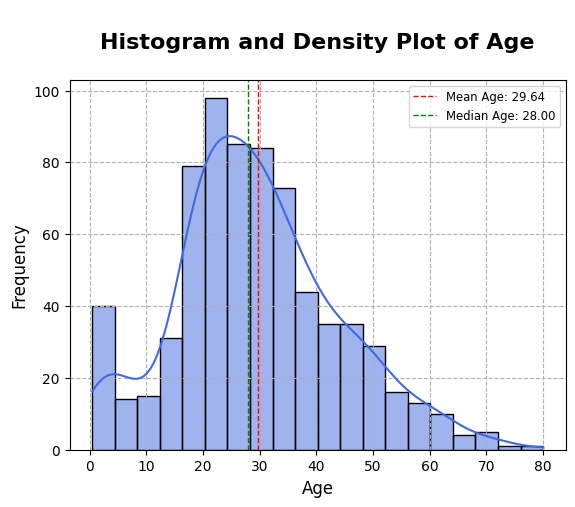

In [17]:
# Create a histogram and a density plot
sns.histplot(df_train['Age'], kde=True, color='royalblue')

# Add a grid to the background of the plot
plt.grid(axis='both', linestyle='--')

# Set the title and labels
plt.title('\nHistogram and Density Plot of Age\n', fontsize=16, weight='bold')
plt.xlabel('Age', fontsize=12)
plt.xticks(fontsize=10)
plt.ylabel('Frequency', fontsize=12)
plt.yticks(fontsize=10)

# Add a vertical line to indicate the mean
mean_age = df_train['Age'].mean()
plt.axvline(mean_age, color='red', linestyle='dashed', linewidth=1, label=f'Mean Age: {mean_age:.2f}')

# Add a vertical line to indicate the median
median_age = df_train['Age'].median()
plt.axvline(median_age, color='green', linestyle='dashed', linewidth=1, label=f'Median Age: {median_age:.2f}')

# Display the plot
plt.legend(fontsize='small')
plt.show()

It's evident that Age have not a normal distribution. Nevertheless, we can run Shapiro test to prove it

In [18]:
# Shapiro-Wilk test with no null values
stat, p_value = shapiro(df_train['Age'].dropna())
print(f'W: {stat}, P value: {p_value}')

# Shapiro-Wilk test results
if p_value > 0.05:
    print('Cannot reject null hypothesis: data has normal distribution')
else:
    print('Null hypothesis rejected: data has no normal distribution')

W: 0.9815096259117126, P value: 7.903165766265374e-08
Null hypothesis rejected: data has no normal distribution


Let's have a look at passengers whose age is null

In [19]:
# Showing passengers whose age is null
df_train[df_train['Age'].isna()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,Q
17,18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,S
19,20,1,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,C
26,27,0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,C
28,29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,Q
...,...,...,...,...,...,...,...,...,...,...,...
857,860,0,3,"Razi, Mr. Raihed",male,NaN,0,0,2629,7.2292,C
861,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.5500,S
866,869,0,3,"van Melkebeke, Mr. Philemon",male,NaN,0,0,345777,9.5000,S
876,879,0,3,"Laleff, Mr. Kristo",male,NaN,0,0,349217,7.8958,S


We can see that there is kind of a pattern in those 177 null registers. Let's see how many passengers with null values have SibSp = 0 and Parch = 0, meaning those passengers who travelled alone.

In [20]:
# Passengers who travelled alone with null age
df_train[df_train['Age'].isna() & (df_train['SibSp'] == 0) & (df_train['Parch'] == 0)]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,Q
17,18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,S
19,20,1,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,C
26,27,0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,C
28,29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,Q
...,...,...,...,...,...,...,...,...,...,...,...
835,838,0,3,"Sirota, Mr. Maurice",male,NaN,0,0,392092,8.0500,S
837,840,1,1,"Marechal, Mr. Pierre",male,NaN,0,0,11774,29.7000,C
857,860,0,3,"Razi, Mr. Raihed",male,NaN,0,0,2629,7.2292,C
866,869,0,3,"van Melkebeke, Mr. Philemon",male,NaN,0,0,345777,9.5000,S


The majority of passengers with null age travelled alone (75 % aprox.). Let's take the data distribution of passengers who travelled alone and its age is not null and apply it to this majority in order to try to replicate the original distribution of passengers who travelled alone.

In [21]:
# Travelled alone distribution
travelled_alone_dist = df_train[df_train['Age'].notna() & (df_train['SibSp'] == 0) & (df_train['Parch'] == 0)]['Age'].value_counts(normalize=True)

# Getting the indexes of passengers who travelled alone
null_travelled_alone_idx = df_train[df_train['Age'].isna() & (df_train['SibSp'] == 0) & (df_train['Parch'] == 0)].index

# Generating values based in the travelled alone distribution with a specific seed
np.random.seed(33)
travelled_alone_generated_age = np.random.choice(travelled_alone_dist.index, size=len(null_travelled_alone_idx), p=travelled_alone_dist)

# Setting generated values into original dataframe
df_train.loc[null_travelled_alone_idx, 'Age'] = travelled_alone_generated_age

# Showing passengers who travelled alone with null age (should be empty)
df_train[df_train['Age'].isnull() & (df_train['SibSp'] == 0) & (df_train['Parch'] == 0)]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked


Let's see the nulls values that remain in Age column.

In [22]:
# Showing passengers whose age is null
df_train[df_train['Age'].isna()].shape

(44, 11)

44 passengers whose age is null remain. Let's set the median of the original column in those remaining registers.

In [23]:
# Filling remaining null values in Age column with the median of the original data
df_train['Age'] = df_train['Age'].fillna(median_age)

Finally, let's check that there isn't any  null values in our data now.

In [24]:
# Nulls values per column
df_train.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

## Outliers

Let's check the outliers of our numerical variables. It is needed to clear up that these variables are: Age, SibSp, Parch and Fare. I consider that Survived and Pclass are categorical which has been translated to numerical.

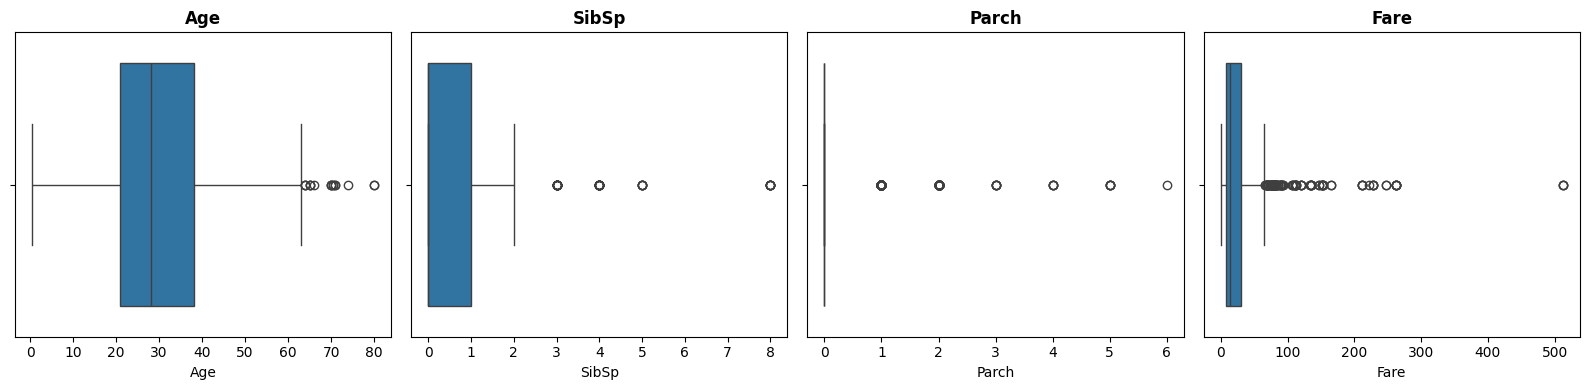

In [25]:
# Selecting columns for which I want to display the boxplot
boxplot_columns = ['Age', 'SibSp', 'Parch', 'Fare']

# Setting subplots
fig, axes = plt.subplots(ncols=len(boxplot_columns), figsize=(4*len(boxplot_columns), 4))

# Iterate over selected columns and creating boxplots
for i, column in enumerate(['Age', 'SibSp', 'Parch', 'Fare']):
    sns.boxplot(x=df_train[column], ax=axes[i])
    axes[i].set_title(f'{column}', weight='bold')

# Adjusting layout and showing boxplots
plt.tight_layout()
plt.show()

Columns more affected by outliers are Age and Fare. Notwithstanding, I am going to keep outliers at least for now because I don't see any value which can be wrong or excessively weird appart from the 500 value outlier of Fare.

## Categorical variables transformation

It's time to prepare our categorical variables to apply ML algorithms.

In [26]:
# Generating numerical columns from categorical columns using labeling
df_train['Sex_Num'] = LabelEncoder().fit_transform(df_train['Sex'])
df_train['Embarked_Num'] = LabelEncoder().fit_transform(df_train['Embarked'])
df_train['Ticket_Num'] = LabelEncoder().fit_transform(df_train['Ticket'])
df_train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Sex_Num,Embarked_Num,Ticket_Num
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,1,2,522
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,0,0,595
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,0,2,668
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,0,2,48
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,1,2,471
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
884,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,S,1,2,100
885,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,S,0,2,14
886,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,28.0,1,2,W./C. 6607,23.4500,S,0,2,674
887,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C,1,0,8


# Variables reduction

Let's try to reduce the number of variables I will work with.

## Correlation matrix

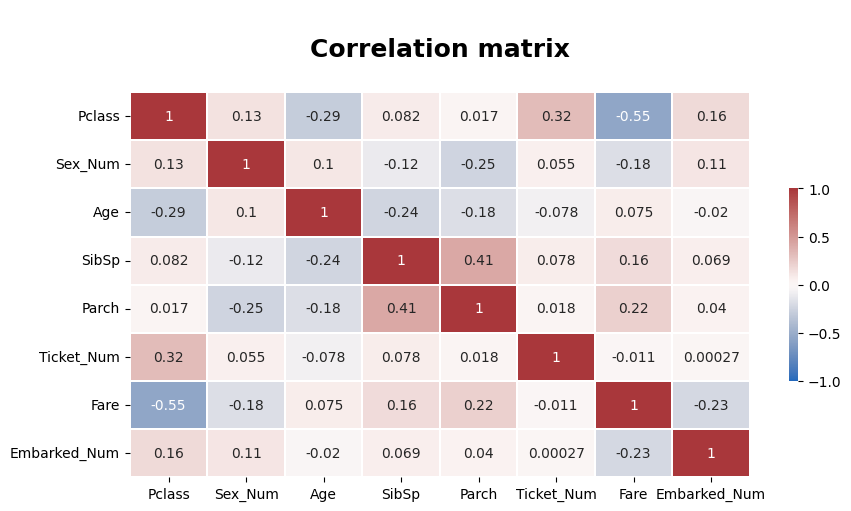

In [27]:
# Plotting correlation matrix
fig, ax = plt.subplots(figsize=(10, 5))
sns.heatmap(df_train[['Pclass', 'Sex_Num', 'Age', 'SibSp', 'Parch', 'Ticket_Num', 'Fare', 'Embarked_Num']].corr(), cmap='vlag', vmax=1, vmin=-1, center=0, linewidths=.15, cbar_kws={"shrink": .5}, annot=True)
ax.set_title("\nCorrelation matrix\n", fontsize=18, weight='bold')
plt.show()

There is no much information we can extract from the correlation matrix. There isn't any variable strongly related to another.

## Variables PCA

In [28]:
# Transpose original dataframe with selected numerical variables
df_train_pca = np.transpose(df_train[['Pclass', 'Sex_Num', 'Age', 'SibSp', 'Parch', 'Ticket_Num', 'Fare', 'Embarked_Num']])
df_train_pca

,0,1,2,3,4,5,6,7,8,9,...,879,880,881,882,883,884,885,886,887,888
Pclass,3.00,1.0000,3.000,1.0,3.00,3.0000,1.0000,3.000,3.0000,2.0000,...,3.0000,3.0000,2.0,3.00,3.000,2.0,1.0,3.00,1.0,3.00
Sex_Num,1.00,0.0000,0.000,0.0,1.00,1.0000,1.0000,1.000,0.0000,0.0000,...,1.0000,0.0000,1.0,1.00,0.000,1.0,0.0,0.00,1.0,1.00
Age,22.00,38.0000,26.000,35.0,35.00,24.0000,54.0000,2.000,27.0000,14.0000,...,33.0000,22.0000,28.0,25.00,39.000,27.0,19.0,28.00,26.0,32.00
SibSp,1.00,1.0000,0.000,1.0,0.00,0.0000,0.0000,3.000,0.0000,1.0000,...,0.0000,0.0000,0.0,0.00,0.000,0.0,0.0,1.00,0.0,0.00
Parch,0.00,0.0000,0.000,0.0,0.00,0.0000,0.0000,1.000,2.0000,0.0000,...,0.0000,0.0000,0.0,0.00,5.000,0.0,0.0,2.00,0.0,0.00
Ticket_Num,522.00,595.0000,668.000,48.0,471.00,274.0000,84.0000,394.000,343.0000,131.0000,...,393.0000,507.0000,564.0,649.00,479.000,100.0,14.0,674.00,8.0,465.00
Fare,7.25,71.2833,7.925,53.1,8.05,8.4583,51.8625,21.075,11.1333,30.0708,...,7.8958,10.5167,10.5,7.05,29.125,13.0,30.0,23.45,30.0,7.75
Embarked_Num,2.00,0.0000,2.000,2.0,2.00,1.0000,2.0000,2.000,2.0000,0.0000,...,2.0000,2.0000,2.0,2.00,1.000,2.0,2.0,2.00,0.0,1.00


In [29]:
# Creamos dataframe con los datos normalizados
df_train_pca = pd.DataFrame(data=StandardScaler().fit_transform(df_train_pca), index=df_train_pca.index)
df_train_pca

,0,1,2,3,4,5,6,7,8,9,...,879,880,881,882,883,884,885,886,887,888
Pclass,-0.390407,-0.452100,-0.389382,-0.747763,-0.403052,-0.402969,-0.736073,-0.390898,-0.407750,-0.479129,...,-0.405601,-0.391825,-0.400345,-0.389150,-0.428037,-0.501255,-0.676986,-0.402482,-0.618986,-0.399457
Sex_Num,-0.402099,-0.457279,-0.403066,-0.793047,-0.416053,-0.425398,-0.736073,-0.406415,-0.434625,-0.526429,...,-0.421205,-0.409892,-0.405759,-0.398540,-0.447342,-0.532341,-0.770364,-0.416097,-0.618986,-0.412615
Age,-0.279332,-0.260456,-0.284471,0.791915,-0.195046,-0.167461,0.943098,-0.398656,-0.192752,-0.195325,...,-0.171542,-0.277405,-0.259564,-0.285854,-0.196372,0.275885,1.003807,-0.289019,1.515448,-0.208672
SibSp,-0.402099,-0.452100,-0.403066,-0.747763,-0.422553,-0.436613,-0.767755,-0.390898,-0.434625,-0.502779,...,-0.429007,-0.409892,-0.411174,-0.403236,-0.447342,-0.563427,-0.770364,-0.411559,-0.704363,-0.419194
Parch,-0.407945,-0.457279,-0.403066,-0.793047,-0.422553,-0.436613,-0.767755,-0.406415,-0.416708,-0.526429,...,-0.429007,-0.409892,-0.411174,-0.403236,-0.415166,-0.563427,-0.770364,-0.407020,-0.704363,-0.419194
Ticket_Num,2.643694,2.624558,2.643909,1.380616,2.639035,2.636207,1.893572,2.642605,2.638057,2.571766,...,2.637170,2.643312,2.642681,2.643994,2.635085,2.545134,0.536920,2.642865,-0.021344,2.639955
Fare,-0.365561,-0.088063,-0.366917,1.611567,-0.370226,-0.341756,0.875377,-0.250667,-0.334890,0.184755,...,-0.367404,-0.346559,-0.354320,-0.370134,-0.259919,-0.159314,2.030959,-0.309669,1.856958,-0.368208
Embarked_Num,-0.396253,-0.457279,-0.393943,-0.702478,-0.409552,-0.425398,-0.704390,-0.398656,-0.416708,-0.526429,...,-0.413403,-0.397847,-0.400345,-0.393845,-0.440907,-0.501255,-0.583609,-0.407020,-0.704363,-0.412615


Variability rate:  [0.88486101 0.09204917]


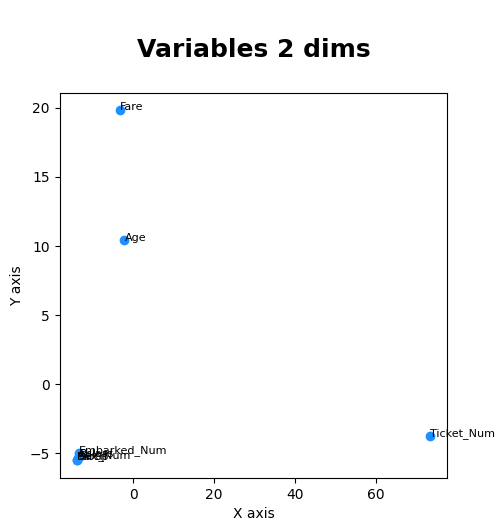

In [30]:
# Instantiating PCA object
vars_pca_obj = PCA(n_components=2)

# Reducing dimensionality to only two dimensions
vars_pca_data = vars_pca_obj.fit_transform(df_train_pca.values)

# Showing variability rate
print("Variability rate: ", vars_pca_obj.explained_variance_ratio_)

# Configuring the plot
fig, ax = plt.subplots(figsize=(5, 5))
plt.title("\nVariables 2 dims\n", fontsize=18, weight='bold')
plt.xlabel("X axis")
plt.ylabel("Y axis")

# Creating the plot
for i, label in enumerate(df_train_pca.index):
    plt.scatter(vars_pca_data[i, 0], vars_pca_data[i, 1], c='dodgerblue')
    plt.annotate(label, (vars_pca_data[i, 0], vars_pca_data[i, 1]), fontsize=8)
plt.show()

I can see that there is some variables that are grouped in (-5, -2) area. I could select one of them to represent the anothers but, taking into account the correlation between them, I don't think that getting one in representation of the others is a good idea.

These variables are the ones with low values not like Fare, Age or Ticket Num so I suppose that this is the cause to be grouped like that. On top of that, except SibSp and Parch which express relationship, the others represents aspect of life so different.

At this point, I can consider Fare, Age and Ticket_Num as outliers and look deeper into the group of the rest of variables to see if I can find some relations and reduce the number of variables which I will work.

## Applying hierarchical clustering with grouped variables

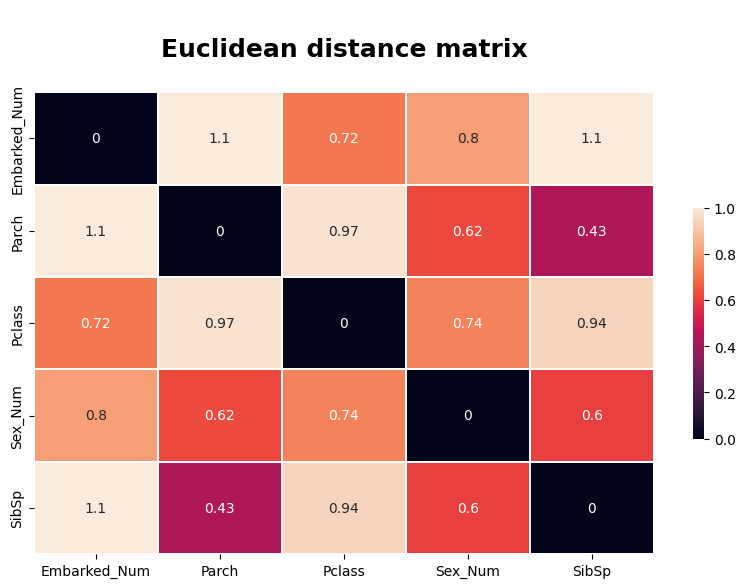

In [31]:
# Creating df with grouped variables
df_train_vars_clust = df_train_pca.loc[df_train_pca.index.difference(['Age', 'Ticket_Num', 'Fare'])]

# Getting euclidean distances
euclidean_dist = metrics.pairwise.euclidean_distances(df_train_vars_clust)

# Plotting euclidean distances matrix
plt.figure(figsize=(10, 6))
sns.heatmap(euclidean_dist, vmin=0, vmax=1, xticklabels=df_train_vars_clust.index, yticklabels=df_train_vars_clust.index, annot=True, linewidths=.15, cbar_kws={"shrink": .5})
plt.title('\nEuclidean distance matrix\n', fontsize=18, weight='bold')
plt.show()

At first sight, none of the grouped variables seems to be nearly significant, except for Parch and SibSp.

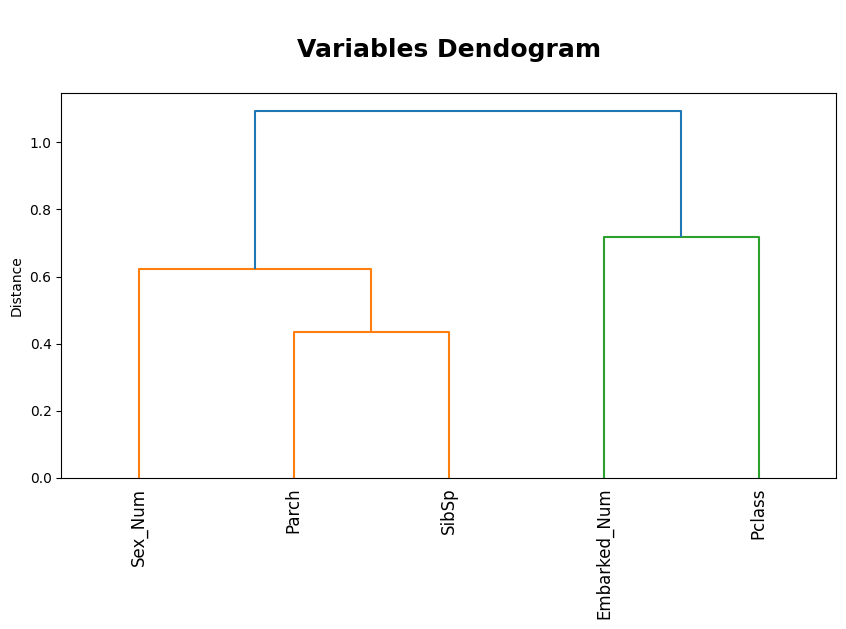

In [32]:
# The hierarchical clustering encoded as a linkage matrix
linkage_matrix = hierarchy.linkage(squareform(euclidean_dist), method='complete')
plt.figure(figsize=(10, 5))
plt.title("\nVariables Dendogram\n", fontsize=18, weight='bold')
plt.ylabel('Distance')
hierarchy.dendrogram(linkage_matrix, color_threshold=0.75, labels=df_train_vars_clust.index, leaf_rotation=90)
plt.show()

One more time it has been shown that Parch and SibSp are the nearest variables. However I don't consider that they are near enough to select one in representation of the other or generate a new variable from them. So, to sum up, I won't reduce the number of variables I will work with.

# Variables generation
Let's try to generate new variables using clustering.

## Samples PCA

In [33]:
# Selecting only numerical variables
num_cols = ['Pclass', 'Sex_Num', 'Age', 'SibSp', 'Parch', 'Ticket_Num', 'Fare', 'Embarked_Num']

# Create normalised df with numerical variables
df_train_sample_clust = pd.DataFrame(data=StandardScaler().fit_transform(df_train[num_cols]), columns=num_cols, index=df_train.index)
df_train_sample_clust

,Pclass,Sex_Num,Age,SibSp,Parch,Ticket_Num,Fare,Embarked_Num
0,0.825209,0.735342,-0.572783,0.431350,-0.474326,0.917018,-0.500240,0.586840
1,-1.572211,-1.359911,0.569463,0.431350,-0.474326,1.281353,0.788947,-1.939555
2,0.825209,-1.359911,-0.287221,-0.475199,-0.474326,1.645689,-0.486650,0.586840
3,-1.572211,-1.359911,0.355292,0.431350,-0.474326,-1.448669,0.422861,0.586840
4,0.825209,0.735342,0.355292,-0.475199,-0.474326,0.662482,-0.484133,0.586840
...,...,...,...,...,...,...,...,...
884,-0.373501,0.735342,-0.215831,-0.475199,-0.474326,-1.189142,-0.384475,0.586840
885,-1.572211,-1.359911,-0.786954,-0.475199,-0.474326,-1.618360,-0.042213,0.586840
886,0.825209,-1.359911,-0.144441,0.431350,2.006119,1.675635,-0.174084,0.586840
887,-1.572211,0.735342,-0.287221,-0.475199,-0.474326,-1.648305,-0.042213,-1.939555


Variability rate:  [0.23567283 0.2195232 ]


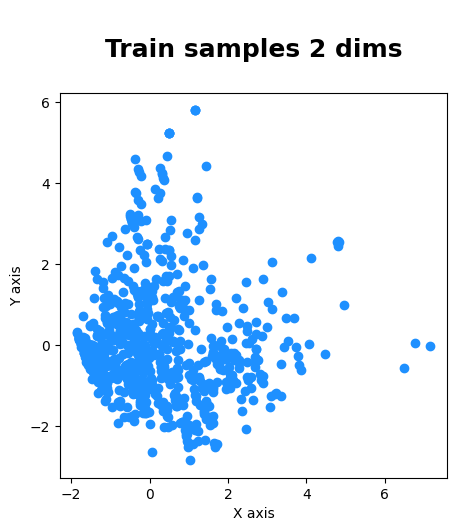

In [34]:
# We need to reduce the dimensionality from 889x8 to 889x2 dimensions
samples_pca_obj = PCA(n_components=2)
samples_pca_data = samples_pca_obj.fit_transform(df_train_sample_clust.values)

# Showing variability rate
print("Variability rate: ", samples_pca_obj.explained_variance_ratio_)

# Configuring the plot
fig, ax = plt.subplots(figsize=(5, 5))
plt.title("\nTrain samples 2 dims\n", fontsize=18, weight='bold')
plt.xlabel("X axis")
plt.ylabel("Y axis")

# Creating the plot
for i in range(len(samples_pca_data)):
    plt.scatter(samples_pca_data[i, 0], samples_pca_data[i, 1], c='dodgerblue')
plt.show()

It seems like there is two clusters and 3 outliers on the right. K-means doesn't perform well with clusters of different sizes and shapes. DBSCAN performs better in that kind of situations. Lets use both to see what happens.

## KMeans

In [35]:
# Let's run a test battery to estimate the optimal number of clusters with elbow and silhouette method
elbow_method_data = []
silhouette_method_data = []

# I am going to test from 2 clusters to 10 clusters
for i in range(2, 11):
  kmeans_battery_test_obj = KMeans(n_init='auto', n_clusters=i, init='k-means++', random_state=33)
  kmeans_battery_test_lbls = kmeans_battery_test_obj.fit_predict(samples_pca_data)
  elbow_method_data.append(kmeans_battery_test_obj.inertia_)
  silhouette_method_data.append(metrics.silhouette_score(samples_pca_data, kmeans_battery_test_lbls))

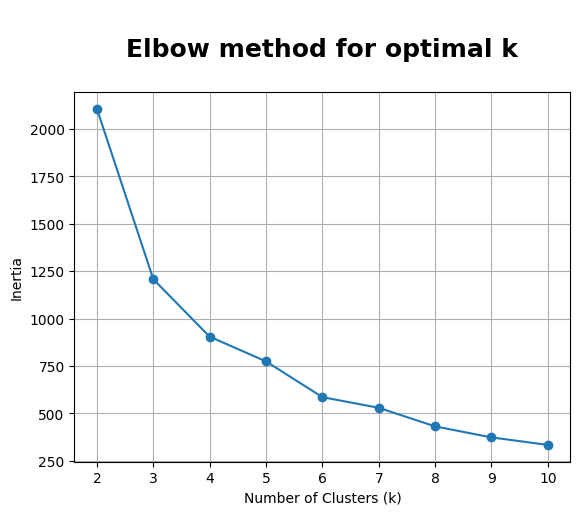

In [36]:


# Plotting data of elbow method for finding the optimal number of clusters
plt.plot(range(2,11), elbow_method_data, marker='o')
plt.xticks(range(2,11))
plt.title("\nElbow method for optimal k\n", fontsize=18, weight='bold')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

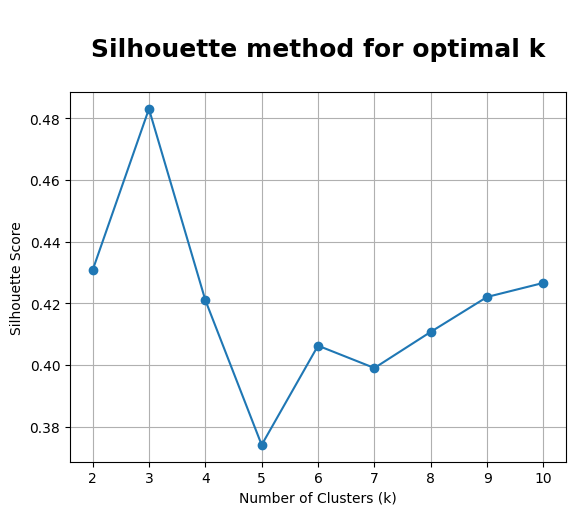

In [37]:

# # Plotting data of silhouette method for finding the optimal number of clusters
plt.plot(range(2,11), silhouette_method_data, marker='o')
plt.xticks(range(2,11))
plt.title("\nSilhouette method for optimal k\n", fontsize=18, weight='bold')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

Both, elbow method and silhouette method indicate that the optimal value of n_clusters should be 3. Let's run KMeans with n_clusters = 3 and show the results.

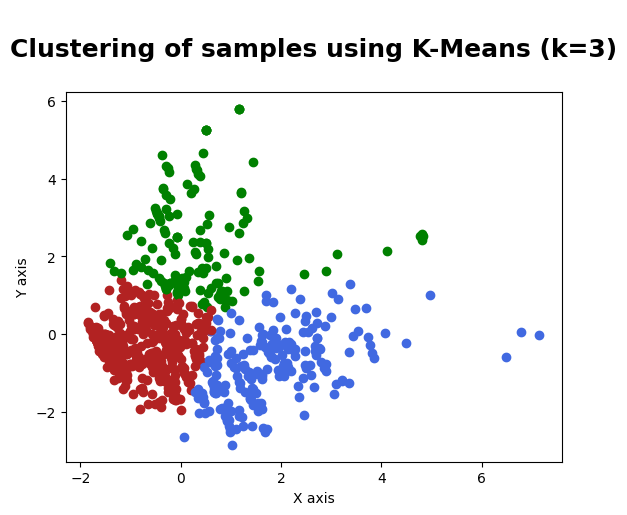

In [38]:
 # Running KMeans with the optimal value for n_clusters parameter
kmeans_samples_obj = KMeans(n_init='auto', n_clusters=3, init='k-means++', random_state=33)
kmeans_samples_lbls = kmeans_samples_obj.fit_predict(samples_pca_data)

# Setting plot title and axis
plt.title("\nClustering of samples using K-Means (k=3)\n", fontsize=18, weight='bold')
plt.xlabel("X axis")
plt.ylabel("Y axis")

# Defining color palette
palette = ['royalblue', 'green', 'firebrick']

# Plotting samples with K-Means labels
for i in range(len(samples_pca_data)):
    plt.scatter(samples_pca_data[i, 0], samples_pca_data[i, 1], c=palette[kmeans_samples_lbls[i]])
plt.show()

Finally, let's add the K-Means cluster labels to the original dataframe, as they might be useful for predicting whether a passenger has survived or not.

In [39]:
# Adding K-Means cluster labels to the original df
df_train['Kmeans_lbl'] = kmeans_samples_lbls
df_train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Sex_Num,Embarked_Num,Ticket_Num,Kmeans_lbl
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,1,2,522,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,0,0,595,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,0,2,668,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,0,2,48,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,1,2,471,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
884,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,S,1,2,100,2
885,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,S,0,2,14,0
886,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,28.0,1,2,W./C. 6607,23.4500,S,0,2,674,1
887,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C,1,0,8,0


## DBSCAN

First thing first. I should estimate the parameters of DBSCAN: eps and min_samples. I can estimate eps with KNN's method but, in order to use that KNN's method I need to have min_samples defined.

There is no way to estimate the parameter min_samples automatically. However, there are a few rules of thumb. For two dimension data it is recommended the default value of DBSCAN, min_samples = 4.

Finally, let's run KNN's method with min_samples = 4.

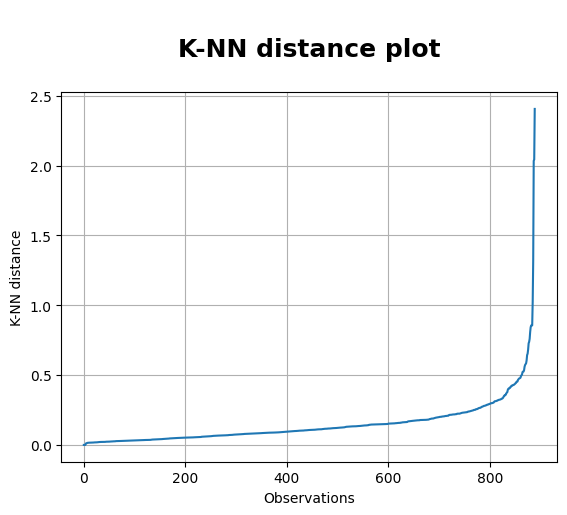

In [40]:
# Running KNN's method
knn_obj = NearestNeighbors(n_neighbors=4)
knn_obj.fit(samples_pca_data)
knn_dist, knn_idxs = knn_obj.kneighbors(samples_pca_data)

# Sort distances
knn_dist = np.sort(knn_dist[:, -1])

# Visualizar las distancias
plt.plot(knn_dist)
plt.ylabel("K-NN distance")
plt.xlabel("Observations")
plt.title('\nK-NN distance plot\n', fontsize=18, weight='bold')
plt.grid(True)
plt.show()

In this case is so difficult to see where is the knee point visually. Fortunately, there is a library which I can estimate the knee point.

eps optimal value:  0.8554624649111163


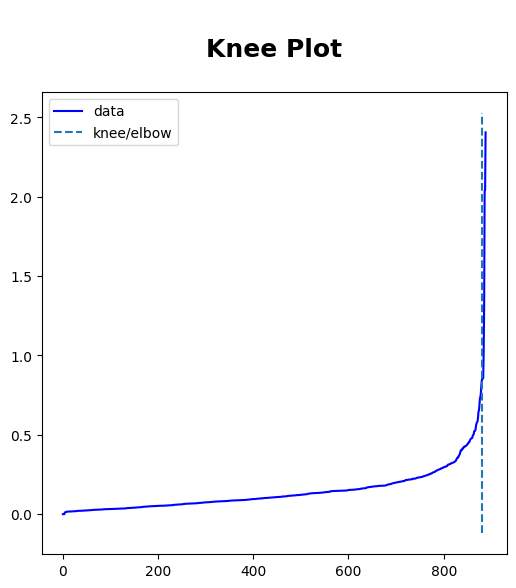

In [41]:
# Estimating knee point and printing it
knee_obj = KneeLocator(x=range(len(knn_dist)), y=knn_dist, curve="concave", direction="increasing", online=True)
print('eps optimal value: ', knee_obj.knee_y)

# Plotting K-NN distance plot with knee point
knee_obj.plot_knee()
plt.title('\nKnee Plot\n', fontsize=18, weight='bold')
plt.show()

Having min_samples and eps values it is time to apply DBSCAN with these values.

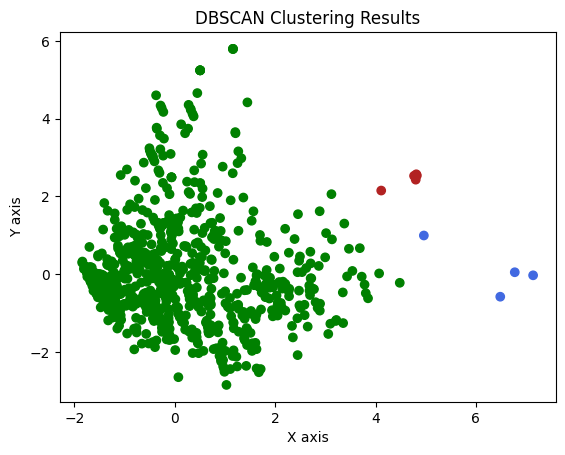

In [42]:
# Running DBSCAN with stimated values for eps and min_samples
dbscan_samples_obj = DBSCAN(eps=0.8554624649111163, min_samples=4)
dbscan_samples_lbls = dbscan_samples_obj.fit_predict(samples_pca_data)

# Defining color palette
palette = {-1: 'royalblue', 0: 'green', 1: 'firebrick'}

# Plotting samples with DBSCAN labels
plt.scatter(samples_pca_data[:, 0], samples_pca_data[:, 1], c=[palette[label] for label in dbscan_samples_lbls])
plt.title('DBSCAN Clustering Results')
plt.xlabel("X axis")
plt.ylabel("Y axis")
plt.show()

As I did with K-Means cluster labels, I am going to add DBSCAN labels to the original dataframe.

In [43]:
# Adding DBSCAN cluster labels to the original df
df_train['DBSCAN_lbl'] = dbscan_samples_lbls
df_train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Sex_Num,Embarked_Num,Ticket_Num,Kmeans_lbl,DBSCAN_lbl
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,1,2,522,2,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,0,0,595,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,0,2,668,2,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,0,2,48,0,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,1,2,471,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
884,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,S,1,2,100,2,0
885,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,S,0,2,14,0,0
886,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,28.0,1,2,W./C. 6607,23.4500,S,0,2,674,1,0
887,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C,1,0,8,0,0


# Prediction

First and foremost we should check the correlation of numeric and generated variables with the target variable (Survived).

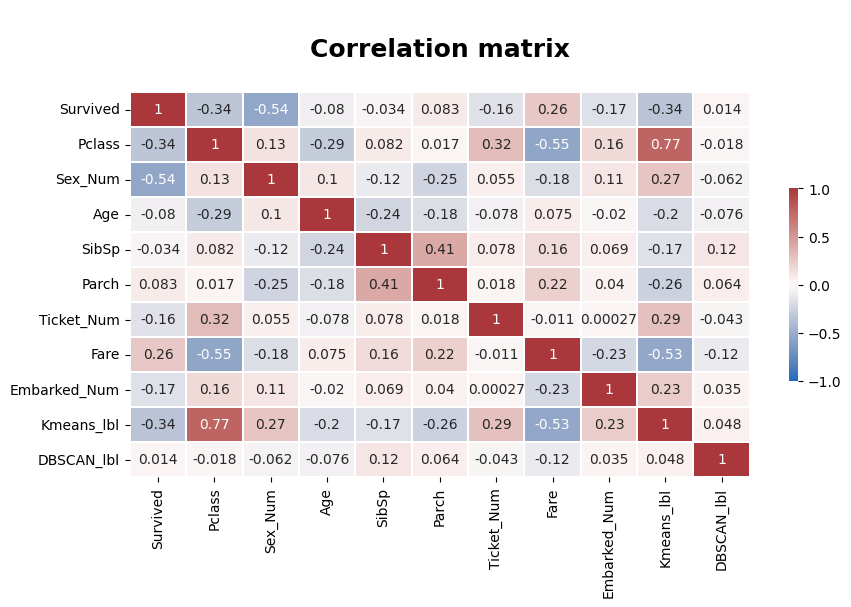

In [44]:
# Plotting correlation matrix
fig, ax = plt.subplots(figsize=(10, 5))
sns.heatmap(df_train[['Survived', 'Pclass', 'Sex_Num', 'Age', 'SibSp', 'Parch', 'Ticket_Num', 'Fare', 'Embarked_Num', 'Kmeans_lbl', 'DBSCAN_lbl']].corr(), cmap='vlag', vmax=1, vmin=-1, center=0, linewidths=.15, cbar_kws={"shrink": .5}, annot=True)
ax.set_title("\nCorrelation matrix\n", fontsize=18, weight='bold')
plt.show()

The correlation matrix shows that there is no highly correlated variables with the target variable. Sex is the most correlated followed by the class and the label I have generated with K-Means.

At this point I should select the variables which I am going to build the predictive model with. Provided that the more variables we choose, the more complex the model will be, I would select only variables whose correlation is higher than 30 %, I mean Pclass, Sex_Num and Kmeans_lbl.

In [45]:
# Creating df with the variables selected for prediciting and target variable
df_train_pred = df_train[['Pclass', 'Sex_Num', 'Kmeans_lbl', 'Survived']]
df_train_pred

,Pclass,Sex_Num,Kmeans_lbl,Survived
0,3,1,2,0
1,1,0,0,1
2,3,0,2,1
3,1,0,0,1
4,3,1,2,0
...,...,...,...,...
884,2,1,2,0
885,1,0,0,1
886,3,0,1,0
887,1,1,0,1


## Test data preparation

The labels that I generated with K-Means are one of the two more correlated variables with the target variable and is going to be part of our prediction models.

Therefore I need that label in my test dataset and I don't have it so I need to generate it. On top of that, not only do I need to generate K-Means label, but also I need to curate the data as I did with train data.

### Duplicates

In [46]:
# Looking for passengers duplicated in test df
print(df_test[df_test.duplicated(['PassengerId'])].shape)
print(df_test[df_test.duplicated(['Name'])].shape)

(0, 11)
(0, 11)


### Nulls

In [47]:
# Nulls values per column in test df
df_test.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [48]:
# Removing Cabin column from test df
df_test = df_test.drop('Cabin', axis=1)

# Showing result
df_test.isna().sum()

PassengerId     0
Pclass          0
Name            0
Sex             0
Age            86
SibSp           0
Parch           0
Ticket          0
Fare            1
Embarked        0
dtype: int64

Due to the submission rules I cannot delete any registers because they expected 418 rows and the header. Thus I cannot remove the register whose Fare value is null.

In [49]:
# Showing the passenger whose Fare is null
df_test[df_test['Fare'].isna()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,S


This passenger traveled alone so, lets get the median of lonely travelers and fill this register with that value.

In [50]:
# Searching for passengers with tickets of the same class, that also traveled alone and who embarked in the same place
df_similar_to_null_fare = df_test[(df_test['Pclass'] == 3) & (df_test['SibSp'] == 0) & (df_test['Parch'] == 0) & (df_test['Embarked'] == 'S')]
df_similar_to_null_fare

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,S
5,897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.2250,S
10,902,3,"Ilieff, Mr. Ylio",male,NaN,0,0,349220,7.8958,S
36,928,3,"Roth, Miss. Sarah A",female,NaN,0,0,342712,8.0500,S
37,929,3,"Cacic, Miss. Manda",female,21.0,0,0,315087,8.6625,S
...,...,...,...,...,...,...,...,...,...,...
398,1290,3,"Larsson-Rondberg, Mr. Edvard A",male,22.0,0,0,347065,7.7750,S
412,1304,3,"Henriksson, Miss. Jenny Lovisa",female,28.0,0,0,347086,7.7750,S
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,S
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,S


Now, let's see the distribution of these similar cases.

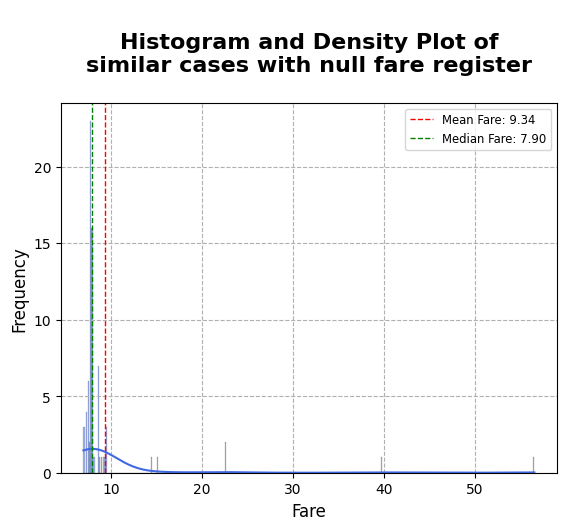

In [51]:
# Create a histogram and a density plot
sns.histplot(df_similar_to_null_fare['Fare'], kde=True, color='royalblue')

# Add a grid to the background of the plot
plt.grid(axis='both', linestyle='--')

# Set the title and labels
plt.title('\nHistogram and Density Plot of\nsimilar cases with null fare register\n', fontsize=16, weight='bold')
plt.xlabel('Fare', fontsize=12)
plt.xticks(fontsize=10)
plt.ylabel('Frequency', fontsize=12)
plt.yticks(fontsize=10)

# Add a vertical line to indicate the mean
mean_fare = df_similar_to_null_fare['Fare'].mean()
plt.axvline(mean_fare, color='red', linestyle='dashed', linewidth=1, label=f'Mean Fare: {mean_fare:.2f}')

# Add a vertical line to indicate the median
median_fare = df_similar_to_null_fare['Fare'].median()
plt.axvline(median_fare, color='green', linestyle='dashed', linewidth=1, label=f'Median Fare: {median_fare:.2f}')

# Display the plot
plt.legend(fontsize='small')
plt.show()

Let's fill the null register of Fare with the mean value of the similar cases. As I am talking about similar cases, I am not afraid of outliers in this case.

In [52]:
# Filling remaining null values in Age column with the median of the original test data
df_test['Fare'] = df_test['Fare'].fillna(mean_fare)

# Showing result
df_test.isna().sum()

PassengerId     0
Pclass          0
Name            0
Sex             0
Age            86
SibSp           0
Parch           0
Ticket          0
Fare            0
Embarked        0
dtype: int64

Finally, let's face the nulls in Age. First thing first, let's see the distribution of Age.

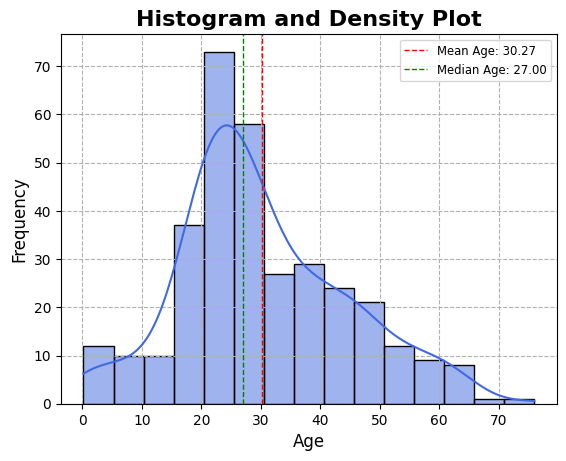

In [53]:
# Create a histogram and a density plot
sns.histplot(df_test['Age'], kde=True, color='royalblue')

# Add a grid to the background of the plot
plt.grid(axis='both', linestyle='--')

# Set the title and labels
plt.title('Histogram and Density Plot', fontsize=16, weight='bold')
plt.xlabel('Age', fontsize=12)
plt.xticks(fontsize=10)
plt.ylabel('Frequency', fontsize=12)
plt.yticks(fontsize=10)

# Add a vertical line to indicate the mean
mean_age = df_test['Age'].mean()
plt.axvline(mean_age, color='red', linestyle='dashed', linewidth=1, label=f'Mean Age: {mean_age:.2f}')

# Add a vertical line to indicate the median
median_age = df_test['Age'].median()
plt.axvline(median_age, color='green', linestyle='dashed', linewidth=1, label=f'Median Age: {median_age:.2f}')

# Display the plot
plt.legend(fontsize='small')
plt.show()

The distribution of Age of test dataset is pretty similar to the train dataset distribution. Let's see if how many passengers with travelled alone are.

In [54]:
# Showing passengers whose age is null in test df
df_test[df_test['Age'].isna()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
10,902,3,"Ilieff, Mr. Ylio",male,NaN,0,0,349220,7.8958,S
22,914,1,"Flegenheim, Mrs. Alfred (Antoinette)",female,NaN,0,0,PC 17598,31.6833,S
29,921,3,"Samaan, Mr. Elias",male,NaN,2,0,2662,21.6792,C
33,925,3,"Johnston, Mrs. Andrew G (Elizabeth Lily"" Watson)""",female,NaN,1,2,W./C. 6607,23.4500,S
36,928,3,"Roth, Miss. Sarah A",female,NaN,0,0,342712,8.0500,S
...,...,...,...,...,...,...,...,...,...,...
408,1300,3,"Riordan, Miss. Johanna Hannah""""",female,NaN,0,0,334915,7.7208,Q
410,1302,3,"Naughton, Miss. Hannah",female,NaN,0,0,365237,7.7500,Q
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,S


In [55]:
# Passengers who travelled alone with null age
df_test[df_test['Age'].isna() & (df_test['SibSp'] == 0) & (df_test['Parch'] == 0)]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
10,902,3,"Ilieff, Mr. Ylio",male,NaN,0,0,349220,7.8958,S
22,914,1,"Flegenheim, Mrs. Alfred (Antoinette)",female,NaN,0,0,PC 17598,31.6833,S
36,928,3,"Roth, Miss. Sarah A",female,NaN,0,0,342712,8.0500,S
39,931,3,"Hee, Mr. Ling",male,NaN,0,0,1601,56.4958,S
41,933,1,"Franklin, Mr. Thomas Parham",male,NaN,0,0,113778,26.5500,S
...,...,...,...,...,...,...,...,...,...,...
384,1276,2,"Wheeler, Mr. Edwin Frederick""""",male,NaN,0,0,SC/PARIS 2159,12.8750,S
408,1300,3,"Riordan, Miss. Johanna Hannah""""",female,NaN,0,0,334915,7.7208,Q
410,1302,3,"Naughton, Miss. Hannah",female,NaN,0,0,365237,7.7500,Q
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,S


Again, it seems that there is a majority of travellers with traveled alone among travelers with null Age. I'll proceed the same way I did in train, replicating the probability of Age of the travelers who traveled alone and using that odds to fill the null data of lonely travelers.

In [56]:
# Travelled alone distribution in test df
travelled_alone_test_dist = df_test[df_test['Age'].notna() & (df_test['SibSp'] == 0) & (df_test['Parch'] == 0)]['Age'].value_counts(normalize=True)

# Getting the indexes of passengers who travelled alone in test df
null_travelled_alone_test_idx = df_test[df_test['Age'].isna() & (df_test['SibSp'] == 0) & (df_test['Parch'] == 0)].index

# Generating values based in the travelled alone distribution with a specific seed
np.random.seed(33)
travelled_alone_generated_age_test = np.random.choice(travelled_alone_test_dist.index, size=len(null_travelled_alone_test_idx), p=travelled_alone_test_dist)

# Setting generated values into original test dataframe
df_test.loc[null_travelled_alone_test_idx, 'Age'] = travelled_alone_generated_age_test

# Showing passengers who travelled alone with null age in test df (should be empty)
df_test[df_test['Age'].isnull() & (df_test['SibSp'] == 0) & (df_test['Parch'] == 0)]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked


In [57]:
# Showing passengers whose age is null in test df
df_test[df_test['Age'].isna()].shape

(19, 10)

There are still registers whose Age is null. I am going to fill them with the median of the original test data, as I did with train data.

In [58]:
# Filling remaining null values in Age column with the median of the original test data
df_test['Age'] = df_test['Age'].fillna(median_age)

# Showing result
df_test.isna().sum()

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

### Outliers
I can see the outliers of test dataframe but, as I did with train data, I am going to keep all the outliers.

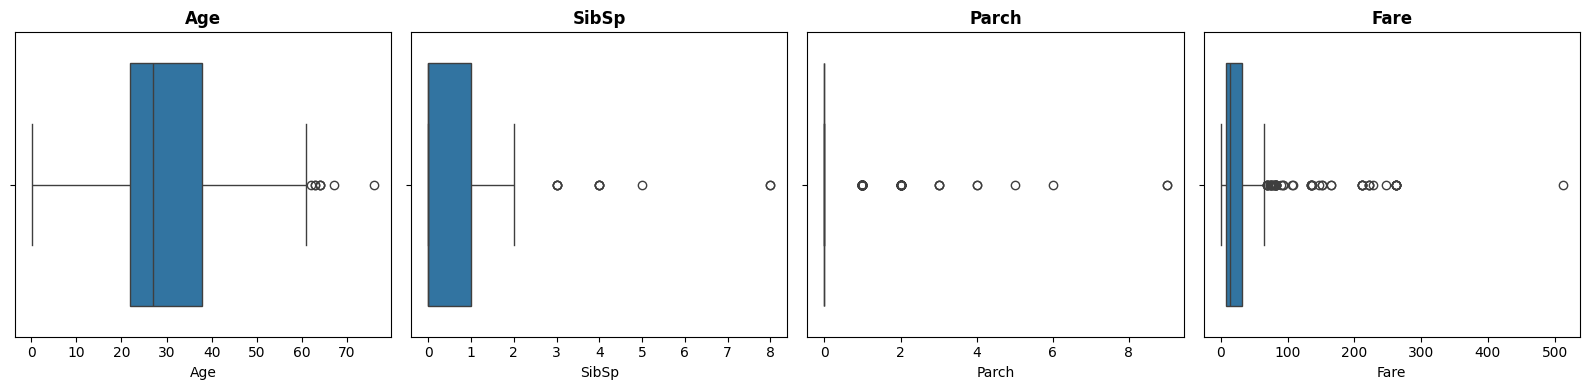

In [59]:
# Selecting columns for which I want to display the boxplot
boxplot_columns = ['Age', 'SibSp', 'Parch', 'Fare']

# Setting subplots
fig, axes = plt.subplots(ncols=len(boxplot_columns), figsize=(4*len(boxplot_columns), 4))

# Iterate over selected columns and creating boxplots
for i, column in enumerate(['Age', 'SibSp', 'Parch', 'Fare']):
    sns.boxplot(x=df_test[column], ax=axes[i])
    axes[i].set_title(f'{column}', weight='bold')

# Adjusting layout and showing boxplots
plt.tight_layout()
plt.show()

### Categorical variables transformation

In [60]:
# Generating numerical columns from categorical columns of test dataframe using labeling
df_test['Sex_Num'] = LabelEncoder().fit_transform(df_test['Sex'])
df_test['Embarked_Num'] = LabelEncoder().fit_transform(df_test['Embarked'])
df_test['Ticket_Num'] = LabelEncoder().fit_transform(df_test['Ticket'])
df_test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Sex_Num,Embarked_Num,Ticket_Num
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,Q,1,1,152
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,S,0,2,221
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,Q,1,1,73
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,S,1,2,147
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,S,0,2,138
...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,20.0,0,0,A.5. 3236,8.0500,S,1,2,267
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C,0,0,324
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,S,1,2,346
416,1308,3,"Ware, Mr. Frederick",male,40.0,0,0,359309,8.0500,S,1,2,220


### KMeans label generation

In [61]:
# Selecting variables we selected with train data
num_cols = ['Pclass', 'Sex_Num', 'Age', 'SibSp', 'Parch', 'Ticket_Num', 'Fare', 'Embarked_Num']

# Normalising test df
df_test_sample_clust = pd.DataFrame(data=StandardScaler().fit_transform(df_test[num_cols]), columns=num_cols, index=df_test.index)
df_test_sample_clust

,Pclass,Sex_Num,Age,SibSp,Parch,Ticket_Num,Fare,Embarked_Num
0,0.873482,0.755929,0.346617,-0.499470,-0.400248,-0.269494,-0.497148,-0.470915
1,0.873482,-1.322876,1.286702,0.616992,-0.400248,0.372934,-0.512011,0.700767
2,-0.315819,0.755929,2.414803,-0.499470,-0.400248,-1.005027,-0.463838,-0.470915
3,0.873482,0.755929,-0.217434,-0.499470,-0.400248,-0.316046,-0.482211,0.700767
4,0.873482,-1.322876,-0.593468,0.616992,0.619896,-0.399841,-0.417233,0.700767
...,...,...,...,...,...,...,...,...
413,0.873482,0.755929,-0.743881,-0.499470,-0.400248,0.801219,-0.493190,0.700767
414,-1.505120,-1.322876,0.685047,-0.499470,-0.400248,1.331921,1.314532,-1.642598
415,0.873482,0.755929,0.647444,-0.499470,-0.400248,1.536753,-0.507530,0.700767
416,0.873482,0.755929,0.760254,-0.499470,-0.400248,0.363624,-0.493190,0.700767


Variability rate:  [0.26820331 0.19229946]


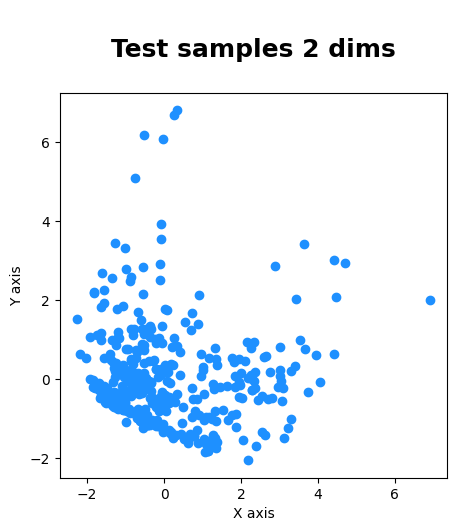

In [62]:
# We need to reduce the dimensionality from 417x8 to 417x2 dimensions
test_samples_pca_obj = PCA(n_components=2)
test_samples_pca_data = test_samples_pca_obj.fit_transform(df_test_sample_clust.values)

# Showing variability rate
print("Variability rate: ", test_samples_pca_obj.explained_variance_ratio_)

# Configuring the plot
fig, ax = plt.subplots(figsize=(5, 5))
plt.title("\nTest samples 2 dims\n", fontsize=18, weight='bold')
plt.xlabel("X axis")
plt.ylabel("Y axis")

# Creating the plot
for i in range(len(test_samples_pca_data)):
    plt.scatter(test_samples_pca_data[i, 0], test_samples_pca_data[i, 1], c='dodgerblue')
plt.show()

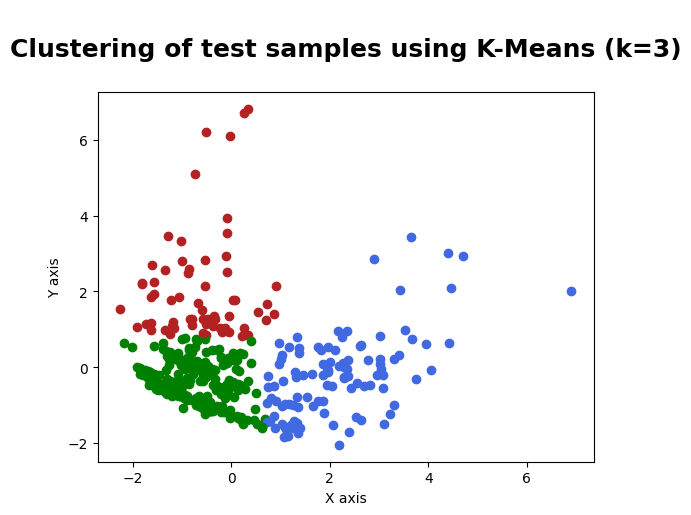

In [63]:
# Running KMeans with data test and the same parametization used with train data
kmeans_test_samples_obj = KMeans(n_init='auto', n_clusters=3, init='k-means++', random_state=33)
kmeans_test_samples_lbls = kmeans_test_samples_obj.fit_predict(test_samples_pca_data)

# Setting plot title and axis
plt.title("\nClustering of test samples using K-Means (k=3)\n", fontsize=18, weight='bold')
plt.xlabel("X axis")
plt.ylabel("Y axis")

# Defining color palette
palette = ['royalblue', 'green', 'firebrick']

# Plotting samples with K-Means labels
for i in range(len(test_samples_pca_data)):
    plt.scatter(test_samples_pca_data[i, 0], test_samples_pca_data[i, 1], c=palette[kmeans_test_samples_lbls[i]])
plt.show()

In [64]:
# Adding K-Means cluster labels to the original test df
df_test['Kmeans_lbl'] = kmeans_test_samples_lbls
df_test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Sex_Num,Embarked_Num,Ticket_Num,Kmeans_lbl
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,Q,1,1,152,1
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,S,0,2,221,1
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,Q,1,1,73,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,S,1,2,147,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,S,0,2,138,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,20.0,0,0,A.5. 3236,8.0500,S,1,2,267,1
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C,0,0,324,0
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,S,1,2,346,1
416,1308,3,"Ware, Mr. Frederick",male,40.0,0,0,359309,8.0500,S,1,2,220,1


## KNN classification

In spite of being expressed as numerical variable, the target variable is categorical. What I want to predict is if a passenger, given its features, is going to survive or not. As a result, the kind of problem I am facing is classification.

I am going to start predicting by using KNN. As I am using only 3 varibles, the model is not too complex and I consider that KNN can perform nicely. First thing I have to do is tunning parameters: n_neighbors and weights. I am going to run a battery of test with cross validation to optimize the values of KNN parameters.

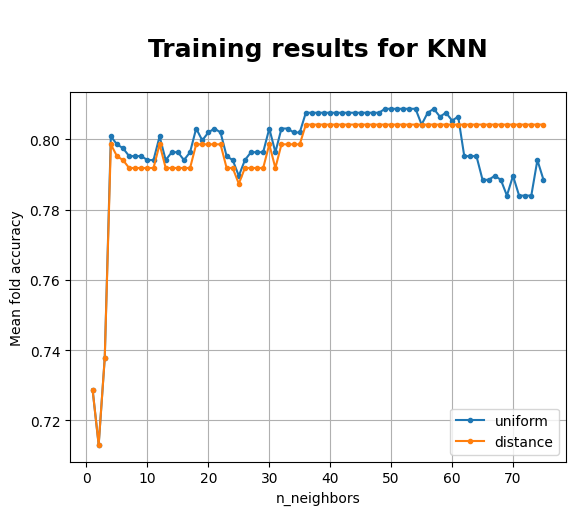

Best model accuracy: 0.8087
Best model parameters: {'n_neighbors': 49, 'weights': 'uniform'}


In [65]:
# Initialising cross-validation
cv_obj = KFold(n_splits=5, shuffle=True, random_state=33)

# Defining the parameter grid
knn_param_grid = {
    'n_neighbors': list(range(1, 76)),
    'weights': ['uniform', 'distance']
}

# Initialising KNeighborsClassifier
knn = KNeighborsClassifier()

# Initialising GridSearchCV
knn_grid_search = GridSearchCV(knn, knn_param_grid, scoring='accuracy', cv=cv_obj)

# Fitting the model
knn_grid_search.fit(df_train_pred.drop(['Survived'], axis=1), df_train_pred['Survived'])

# Extracting results
knn_training_results = knn_grid_search.cv_results_
best_knn_params = knn_grid_search.best_params_
best_knn_accuracy = knn_grid_search.best_score_
best_knn_model = knn_grid_search.best_estimator_

# Getting mean accuracies from training results
uniform_accuracies = knn_training_results['mean_test_score'][::2]
distance_accuracies = knn_training_results['mean_test_score'][1::2]

# Plotting the results
plt.plot(knn_param_grid['n_neighbors'], uniform_accuracies, marker='.', label='uniform')
plt.plot(knn_param_grid['n_neighbors'], distance_accuracies, marker='.', label='distance')
plt.xlabel('n_neighbors')
plt.ylabel('Mean fold accuracy')
plt.title('\nTraining results for KNN\n', fontsize=18, weight='bold')
plt.legend()
plt.grid(True)
plt.show()

# Printing the best model accuracy and parameters
print(f'Best model accuracy: {best_knn_accuracy:.4f}')
print(f'Best model parameters: {best_knn_params}')

As it can be seen in the plot, both weights, uniform and distance, perform similarly and the results are almost the same. Nevertheless, I am going to use distance because the result is slightly better.

In [66]:
# Creating df with the variables selected for prediciting and target variable
df_test_pred = df_test[['Pclass', 'Sex_Num', 'Kmeans_lbl']]
df_test_pred

,Pclass,Sex_Num,Kmeans_lbl
0,3,1,1
1,3,0,1
2,2,1,0
3,3,1,1
4,3,0,2
...,...,...,...
413,3,1,1
414,1,0,0
415,3,1,1
416,3,1,1


In [67]:
# Using best KNN model to making predictions with test data
knn_predicts = best_knn_model.predict(df_test[['Pclass', 'Sex_Num', 'Kmeans_lbl']])

# Adding KNN predictions to original test df
df_test['Survived_KNN_3in'] = knn_predicts
df_test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Sex_Num,Embarked_Num,Ticket_Num,Kmeans_lbl,Survived_KNN_3in
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,Q,1,1,152,1,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,S,0,2,221,1,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,Q,1,1,73,0,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,S,1,2,147,1,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,S,0,2,138,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,20.0,0,0,A.5. 3236,8.0500,S,1,2,267,1,0
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C,0,0,324,0,1
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,S,1,2,346,1,0
416,1308,3,"Ware, Mr. Frederick",male,40.0,0,0,359309,8.0500,S,1,2,220,1,0


In [68]:
# Generating submission file
pd.DataFrame({'PassengerId': df_test['PassengerId'], 'Survived': df_test['Survived_KNN_3in']}).to_csv('titanic/results/knn_3in_submission_file.csv', index=False)

In [69]:
# Uploading data to Kaggle
#!kaggle competitions submit -c titanic -f knn_3in_submission_file.csv -m "KNN: n_neighbors=49 and weight=uniform. Input: Pclass, Sex_Num and Kmeans_lbl. 5 folds in cross-validation."

# Acc --> 67.464 %

What if I reduce the model complexity? As there are only 3 "highly" correlated variables and 2 of them have -0.34, let's try to remove one of these variables to reduce model complexity.

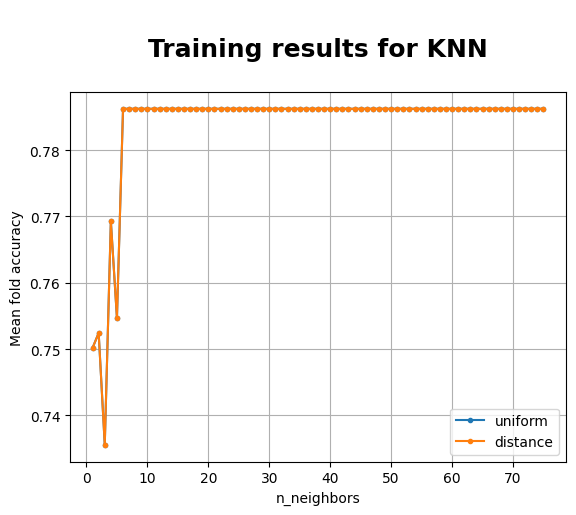

Best model accuracy: 0.7862
Best model parameters: {'n_neighbors': 6, 'weights': 'uniform'}


In [70]:
# Initializing KNeighborsClassifier
knn = KNeighborsClassifier()

# Initializing GridSearchCV
knn_grid_search = GridSearchCV(knn, knn_param_grid, scoring='accuracy', cv=cv_obj)

# Fitting the model
knn_grid_search.fit(df_train_pred.drop(['Kmeans_lbl', 'Survived'], axis=1), df_train_pred['Survived'])

# Extracting results
search_results = knn_grid_search.cv_results_
best_knn_params = knn_grid_search.best_params_
best_knn_accuracy = knn_grid_search.best_score_
best_knn_model = knn_grid_search.best_estimator_

# Getting mean accuracies from training results
uniform_accs = search_results['mean_test_score'][::2]
distance_accs = search_results['mean_test_score'][1::2]

# Plotting the results
plt.plot(knn_param_grid['n_neighbors'], uniform_accs, marker='.', label='uniform')
plt.plot(knn_param_grid['n_neighbors'], distance_accs, marker='.', label='distance')
plt.xlabel('n_neighbors')
plt.ylabel('Mean fold accuracy')
plt.title('\nTraining results for KNN\n', fontsize=18, weight='bold')
plt.legend()
plt.grid(True)
plt.show()

# Printing the best model accuracy and parameters
print(f'Best model accuracy: {best_knn_accuracy:.4f}')
print(f'Best model parameters: {best_knn_params}')

In [71]:
# Using best KNN model to making predictions with test data
knn_predicts = best_knn_model.predict(df_test[['Pclass', 'Sex_Num']])

# Adding KNN predictions to original test df
df_test['Survived_KNN_2in'] = knn_predicts
df_test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Sex_Num,Embarked_Num,Ticket_Num,Kmeans_lbl,Survived_KNN_3in,Survived_KNN_2in
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,Q,1,1,152,1,0,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,S,0,2,221,1,0,1
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,Q,1,1,73,0,0,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,S,1,2,147,1,0,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,S,0,2,138,2,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,20.0,0,0,A.5. 3236,8.0500,S,1,2,267,1,0,0
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C,0,0,324,0,1,1
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,S,1,2,346,1,0,0
416,1308,3,"Ware, Mr. Frederick",male,40.0,0,0,359309,8.0500,S,1,2,220,1,0,0


In [72]:
# Generating submission file
pd.DataFrame({'PassengerId': df_test['PassengerId'], 'Survived': df_test['Survived_KNN_2in']}).to_csv('titanic/results/knn_2in_submission_file.csv', index=False)

In [73]:
# Uploading data to Kaggle
#!kaggle competitions submit -c titanic -f knn_2in_submission_file.csv -m "KNN: n_neighbors=6 and weight=uniform. Input: Pclass and Sex_Num. 5 folds in cross-validation."

# Acc --> 76.555 %

By reducing the complexity of the model I have obtained more accuracy and the model generalises better.

In [74]:
# Removing labels with less accuracy
df_test.drop('Survived_KNN_3in', axis=1, inplace=True)

# Removing CSVs with less accuracy
!rm titanic/results/knn_3in_submission_file.csv

## Naive Bayes
Let's see what happens if we use Naive Bayes to solve the problem. There are several Naive Bayes' classifiers so I am going to set a battery test with the different classifiers and several values for the parameters that each classifier needs.

In [75]:
# Defining classifiers
classifiers = {
    'GaussianNB': GaussianNB(),
    'MultinomialNB': MultinomialNB(),
    'BernoulliNB': BernoulliNB(),
    'ComplementNB': ComplementNB(),
}

# Defining the parameters for each classifiers
nb_param_grids = {
    'GaussianNB': {},  # GaussianNB no tiene hiperparámetros para ajustar
    'MultinomialNB': {'alpha': [i / 10 for i in range(1, 11)]},  # Ajusta según tu necesidad
    'BernoulliNB': {'alpha': [i / 10 for i in range(1, 11)], 'binarize': [i / 10 for i in range(11)]},  # Ajusta según tu necesidad
    'ComplementNB': {'alpha': [i / 10 for i in range(1, 11)]},  # Ajusta según tu necesidad
}

# Initialising dictionaries to save best models and training results
best_nb_models = {}
best_nb_accuracies = {}

# Iterating over classifiers
for clf_name, clf_obj in classifiers.items():

    # Getting parameter grid of the corresponding classifier
    param_grid = nb_param_grids[clf_name]

    # Initialising GridSearchCV
    nb_grid_search = GridSearchCV(clf_obj, param_grid, scoring='accuracy', cv=cv_obj)

    # Fitting the model
    nb_grid_search.fit(df_train_pred.drop('Survived', axis=1), df_train_pred['Survived'])

    # Saving best model and best parameters for each classifier
    best_nb_models[clf_name] = nb_grid_search.best_estimator_
    best_nb_accuracies[clf_name] = nb_grid_search.best_score_

    # Printing results
    print(f'Best accuracy for {clf_name}: {best_nb_accuracies[clf_name]:.4f}')
    print(f'Best parameters for {clf_name}: {nb_grid_search.best_params_}\n')

Best accuracy for GaussianNB: 0.7480
Best parameters for GaussianNB: {}

Best accuracy for MultinomialNB: 0.6096
Best parameters for MultinomialNB: {'alpha': 0.1}

Best accuracy for BernoulliNB: 0.7862
Best parameters for BernoulliNB: {'alpha': 0.1, 'binarize': 0.0}

Best accuracy for ComplementNB: 0.7862
Best parameters for ComplementNB: {'alpha': 0.1}



In [76]:
# Getting the two best models (there is a tie)
best_bernoulli_nb_model = best_nb_models['BernoulliNB']
best_complement_nb_model = best_nb_models['ComplementNB']

# Using best NB models to making predictions with test data
bernoulli_nb_predicts = best_bernoulli_nb_model.predict(df_test[['Pclass', 'Sex_Num', 'Kmeans_lbl']])
complement_nb_predicts = best_complement_nb_model.predict(df_test[['Pclass', 'Sex_Num', 'Kmeans_lbl']])

# Adding NB predictions to original test df
df_test['Survived_BernoulliNB_3in'] = bernoulli_nb_predicts
df_test['Survived_ComplementNB_3in'] = complement_nb_predicts
df_test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Sex_Num,Embarked_Num,Ticket_Num,Kmeans_lbl,Survived_KNN_2in,Survived_BernoulliNB_3in,Survived_ComplementNB_3in
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,Q,1,1,152,1,0,0,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,S,0,2,221,1,1,1,1
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,Q,1,1,73,0,0,0,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,S,1,2,147,1,0,0,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,S,0,2,138,2,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,20.0,0,0,A.5. 3236,8.0500,S,1,2,267,1,0,0,0
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C,0,0,324,0,1,1,1
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,S,1,2,346,1,0,0,0
416,1308,3,"Ware, Mr. Frederick",male,40.0,0,0,359309,8.0500,S,1,2,220,1,0,0,0


In [77]:
# Generating submissions file
pd.DataFrame({'PassengerId': df_test['PassengerId'], 'Survived': df_test['Survived_BernoulliNB_3in']}).to_csv('titanic/results/BernoulliNB_3in_submission_file.csv', index=False)
pd.DataFrame({'PassengerId': df_test['PassengerId'], 'Survived': df_test['Survived_ComplementNB_3in']}).to_csv('titanic/results/ComplementNB_3in_submission_file.csv', index=False)

In [78]:
# Uploading data to Kaggle
#!kaggle competitions submit -c titanic -f BernoulliNB_3in_submission_file.csv -m "BernoulliNB: alpha=0.1 and binarize=0.0. Input: Pclass, Sex_Num and Kmeans_lbl. 5 folds in cross-validation. Version 2."
#!kaggle competitions submit -c titanic -f ComplementNB_3in_submission_file.csv -m "ComplementNB: alpha=0.1. Input: Pclass, Sex_Num and Kmeans_lbl. 5 folds in cross-validation. Version 2."

# BernoulliNB Acc --> 76.555 %
# ComplementNB Acc --> 76.555 %

With a model of 3 variables of input I have achieved the same accuracy as KNN with 2. As we did with KNN, let's see what happens if I reduce the model complexity.

In [79]:
# Initialising dictionaries to save best models and training results
best_nb_models = {}
best_nb_accuracies = {}

# Iterating over classifiers
for clf_name, clf_obj in classifiers.items():

    # Getting parameter grid of the corresponding classifier
    param_grid = nb_param_grids[clf_name]

    # Initialising GridSearchCV
    nb_grid_search = GridSearchCV(clf_obj, param_grid, scoring='accuracy', cv=cv_obj)

    # Fitting the model
    nb_grid_search.fit(df_train_pred.drop(['Kmeans_lbl', 'Survived'], axis=1), df_train_pred['Survived'])

    # Saving best model and best parameters for each classifier
    best_nb_models[clf_name] = nb_grid_search.best_estimator_
    best_nb_accuracies[clf_name] = nb_grid_search.best_score_

    # Printing results
    print(f'Best accuracy for {clf_name}: {best_nb_accuracies[clf_name]:.4f}')
    print(f'Best parameters for {clf_name}: {nb_grid_search.best_params_}\n')

Best accuracy for GaussianNB: 0.7862
Best parameters for GaussianNB: {}

Best accuracy for MultinomialNB: 0.6175
Best parameters for MultinomialNB: {'alpha': 0.1}

Best accuracy for BernoulliNB: 0.7862
Best parameters for BernoulliNB: {'alpha': 0.1, 'binarize': 0.0}

Best accuracy for ComplementNB: 0.7862
Best parameters for ComplementNB: {'alpha': 0.1}



In [80]:
# Getting the three best models (there is a tie)
best_gaussian_nb_model = best_nb_models['GaussianNB']
best_bernoulli_nb_model = best_nb_models['BernoulliNB']
best_complement_nb_model = best_nb_models['ComplementNB']

# Using best NB models to making predictions with test data
gaussian_nb_predicts = best_gaussian_nb_model.predict(df_test[['Pclass', 'Sex_Num']])
bernoulli_nb_predicts = best_bernoulli_nb_model.predict(df_test[['Pclass', 'Sex_Num']])
complement_nb_predicts = best_complement_nb_model.predict(df_test[['Pclass', 'Sex_Num']])

# Adding NB predictions to original test df
df_test['Survived_GaussianNB_2in'] = gaussian_nb_predicts
df_test['Survived_BernoulliNB_2in'] = bernoulli_nb_predicts
df_test['Survived_ComplementNB_2in'] = complement_nb_predicts
df_test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Sex_Num,Embarked_Num,Ticket_Num,Kmeans_lbl,Survived_KNN_2in,Survived_BernoulliNB_3in,Survived_ComplementNB_3in,Survived_GaussianNB_2in,Survived_BernoulliNB_2in,Survived_ComplementNB_2in
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,Q,1,1,152,1,0,0,0,0,0,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,S,0,2,221,1,1,1,1,1,1,1
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,Q,1,1,73,0,0,0,0,0,0,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,S,1,2,147,1,0,0,0,0,0,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,S,0,2,138,2,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,20.0,0,0,A.5. 3236,8.0500,S,1,2,267,1,0,0,0,0,0,0
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C,0,0,324,0,1,1,1,1,1,1
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,S,1,2,346,1,0,0,0,0,0,0
416,1308,3,"Ware, Mr. Frederick",male,40.0,0,0,359309,8.0500,S,1,2,220,1,0,0,0,0,0,0


In [81]:
# Generating submissions file
pd.DataFrame({'PassengerId': df_test['PassengerId'], 'Survived': df_test['Survived_GaussianNB_2in']}).to_csv('titanic/results/GaussianNB_2in_submission_file.csv', index=False)
pd.DataFrame({'PassengerId': df_test['PassengerId'], 'Survived': df_test['Survived_BernoulliNB_2in']}).to_csv('titanic/results/BernoulliNB_2in_submission_file.csv', index=False)
pd.DataFrame({'PassengerId': df_test['PassengerId'], 'Survived': df_test['Survived_ComplementNB_2in']}).to_csv('titanic/results/ComplementNB_2in_submission_file.csv', index=False)

In [82]:
# Uploading data to Kaggle
#!kaggle competitions submit -c titanic -f GaussianNB_2in_submission_file.csv -m "GaussianNB. Input: Pclass and Sex_Num. 5 folds in cross-validation."
#!kaggle competitions submit -c titanic -f BernoulliNB_2in_submission_file.csv -m "BernoulliNB: alpha=0.1 and binarize=0.0. Input: Pclass and Sex_Num. 5 folds in cross-validation."
#!kaggle competitions submit -c titanic -f ComplementNB_2in_submission_file.csv -m "ComplementNB: alpha=0.1. Input: Pclass and Sex_Num. 5 folds in cross-validation."

# GaussianNB Acc --> 76.555 %
# BernoulliNB Acc --> 76.555 %
# ComplementNB Acc --> 76.555 %

In this case, reducing model's complexity hasn't been helpful. Anyway, a NB model should be selected so, I am going to choose the simpliest. That model is GaussianNB with two variables as input.

In [83]:
# Removing labels of not selected models
df_test.drop('Survived_BernoulliNB_3in', axis=1, inplace=True)
df_test.drop('Survived_ComplementNB_3in', axis=1, inplace=True)
df_test.drop('Survived_BernoulliNB_2in', axis=1, inplace=True)
df_test.drop('Survived_ComplementNB_2in', axis=1, inplace=True)

# Removing CSVs of not selected models
!rm titanic/results/BernoulliNB_3in_submission_file.csv
!rm titanic/results/ComplementNB_3in_submission_file.csv
!rm titanic/results/BernoulliNB_2in_submission_file.csv
!rm titanic/results/ComplementNB_2in_submission_file.csv

## SVM
Now I will use SVM to make the predictions.

In [84]:
# Defining the parameter grid for SVM
svm_param_grid = {
    'C': list(range(1, 51)),
    'kernel': ['rbf', 'poly', 'sigmoid'],
    'gamma': ['scale', 'auto', 0.1, 0.5, 0.01, 0.05, 0.001, 0.005, 0.0001, 0.0005]
}

# Initialising Support Vector Machine (SVM)
svm = SVC()

# Initialising GridSearchCV
svm_grid_search = GridSearchCV(svm, svm_param_grid, scoring='accuracy', cv=cv_obj)

# Fitting the model
svm_grid_search.fit(df_train_pred.drop(['Survived'], axis=1), df_train_pred['Survived'])

# Extracting results
best_svm_params = svm_grid_search.best_params_
best_svm_accuracy = svm_grid_search.best_score_
best_svm_model = svm_grid_search.best_estimator_

# Printing the best model accuracy and parameters
print(f'Best SVM model accuracy: {best_svm_accuracy:.4f}')
print(f'Best SVM model parameters: {best_svm_params}')

Best SVM model accuracy: 0.8098
Best SVM model parameters: {'C': 36, 'gamma': 0.1, 'kernel': 'rbf'}


In [85]:
# Using best SVM models to making predictions with test data
svm_predicts = best_svm_model.predict(df_test[['Pclass', 'Sex_Num', 'Kmeans_lbl']])

# Adding SVM predictions to original test df
df_test['Survived_SVM_3in'] = svm_predicts
df_test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Sex_Num,Embarked_Num,Ticket_Num,Kmeans_lbl,Survived_KNN_2in,Survived_GaussianNB_2in,Survived_SVM_3in
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,Q,1,1,152,1,0,0,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,S,0,2,221,1,1,1,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,Q,1,1,73,0,0,0,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,S,1,2,147,1,0,0,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,S,0,2,138,2,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,20.0,0,0,A.5. 3236,8.0500,S,1,2,267,1,0,0,0
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C,0,0,324,0,1,1,1
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,S,1,2,346,1,0,0,0
416,1308,3,"Ware, Mr. Frederick",male,40.0,0,0,359309,8.0500,S,1,2,220,1,0,0,0


In [86]:
# Generating submissions file
pd.DataFrame({'PassengerId': df_test['PassengerId'], 'Survived': df_test['Survived_SVM_3in']}).to_csv('titanic/results/SVM_3in_submission_file.csv', index=False)

In [87]:
# Uploading data to Kaggle
#!kaggle competitions submit -c titanic -f titanic/results/SVM_3in_submission_file.csv -m "SVM: C=36, gamma=0.1 and kernel=rbf. Input: Pclass, Sex_Num and Kmeans_lbl. 5 folds in cross-validation."

# SVM Acc --> 66.985 %

In spite of getting the best accuracy with validation dataset, the accuracy with test data is 66.98 % which is not the best I have achieved. Let's, as I did previously, reduce model's complexity.

In [88]:
# Initialising Support Vector Machine (SVM)
svm = SVC()

# Initialising GridSearchCV
svm_grid_search = GridSearchCV(svm, svm_param_grid, scoring='accuracy', cv=cv_obj)

# Fitting the model
svm_grid_search.fit(df_train_pred.drop(['Kmeans_lbl', 'Survived'], axis=1), df_train_pred['Survived'])

# Extracting results
best_svm_params = svm_grid_search.best_params_
best_svm_accuracy = svm_grid_search.best_score_
best_svm_model = svm_grid_search.best_estimator_

# Printing the best model accuracy and parameters
print(f'Best SVM model accuracy: {best_svm_accuracy:.4f}')
print(f'Best SVM model parameters: {best_svm_params}')

Best SVM model accuracy: 0.7862
Best SVM model parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'poly'}


In [89]:
# Using best SVM models to making predictions with test data
svm_predicts = best_svm_model.predict(df_test[['Pclass', 'Sex_Num']])

# Adding SVM predictions to original test df
df_test['Survived_SVM_2in'] = svm_predicts
df_test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Sex_Num,Embarked_Num,Ticket_Num,Kmeans_lbl,Survived_KNN_2in,Survived_GaussianNB_2in,Survived_SVM_3in,Survived_SVM_2in
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,Q,1,1,152,1,0,0,0,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,S,0,2,221,1,1,1,0,1
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,Q,1,1,73,0,0,0,0,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,S,1,2,147,1,0,0,0,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,S,0,2,138,2,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,20.0,0,0,A.5. 3236,8.0500,S,1,2,267,1,0,0,0,0
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C,0,0,324,0,1,1,1,1
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,S,1,2,346,1,0,0,0,0
416,1308,3,"Ware, Mr. Frederick",male,40.0,0,0,359309,8.0500,S,1,2,220,1,0,0,0,0


In [90]:
# Generating submissions file
pd.DataFrame({'PassengerId': df_test['PassengerId'], 'Survived': df_test['Survived_SVM_2in']}).to_csv('titanic/results/SVM_2in_submission_file.csv', index=False)

In [91]:
# Uploading data to Kaggle
#!kaggle competitions submit -c titanic -f titanic/results/SVM_2in_submission_file.csv -m "SVM: C=1, gamma=scale and kernel=poly. Input: Pclass and Sex_Num. 5 folds in cross-validation."

# SVM Acc --> 76.555 %

In [92]:
# Removing labels of not selected models
df_test.drop('Survived_SVM_3in', axis=1, inplace=True)

# Removing CSVs of not selected models
!rm titanic/results/SVM_3in_submission_file.csv

## Decision trees
Finally, I will use decision trees to make the predictions.

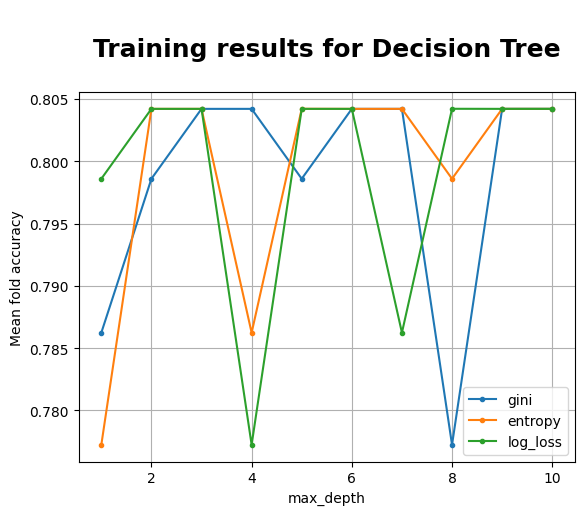

Best model accuracy: 0.8042
Best model parameters: {'criterion': 'entropy', 'max_depth': 4}


In [93]:
# Define the parameter grid for Decision Tree
dt_param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': list(range(1, 11))
}

# Initialize DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=33)

# Initialize GridSearchCV
dt_grid_search = GridSearchCV(dt, dt_param_grid, scoring='accuracy', cv=cv_obj)

# Fit the model
dt_grid_search.fit(df_train_pred.drop(['Survived'], axis=1), df_train_pred['Survived'])

# Extract results
dt_training_results = dt_grid_search.cv_results_
best_dt_params = dt_grid_search.best_params_
best_dt_accuracy = dt_grid_search.best_score_
best_dt_model = dt_grid_search.best_estimator_

# Get mean accuracies from training results
gini_accuracies = dt_training_results['mean_test_score'][::3]
entropy_accuracies = dt_training_results['mean_test_score'][1::3]
log_loss_accuracies = dt_training_results['mean_test_score'][2::3]

# Plot the results
plt.plot(range(1, 11), gini_accuracies, marker='.', label='gini')
plt.plot(range(1, 11), entropy_accuracies, marker='.', label='entropy')
plt.plot(range(1, 11), log_loss_accuracies, marker='.', label='log_loss')
plt.xlabel('max_depth')
plt.ylabel('Mean fold accuracy')
plt.title('\nTraining results for Decision Tree\n', fontsize=18, weight='bold')
plt.legend()
plt.grid(True)
plt.show()

# Print the best model accuracy and parameters
print(f'Best model accuracy: {best_dt_accuracy:.4f}')
print(f'Best model parameters: {best_dt_params}')

In [94]:
# Using best DT model to making predictions with test data
dt_predicts = best_dt_model.predict(df_test[['Pclass', 'Sex_Num', 'Kmeans_lbl']])

# Adding DT predictions to original test df
df_test['Survived_DT_3in'] = dt_predicts
df_test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Sex_Num,Embarked_Num,Ticket_Num,Kmeans_lbl,Survived_KNN_2in,Survived_GaussianNB_2in,Survived_SVM_2in,Survived_DT_3in
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,Q,1,1,152,1,0,0,0,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,S,0,2,221,1,1,1,1,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,Q,1,1,73,0,0,0,0,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,S,1,2,147,1,0,0,0,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,S,0,2,138,2,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,20.0,0,0,A.5. 3236,8.0500,S,1,2,267,1,0,0,0,0
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C,0,0,324,0,1,1,1,1
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,S,1,2,346,1,0,0,0,0
416,1308,3,"Ware, Mr. Frederick",male,40.0,0,0,359309,8.0500,S,1,2,220,1,0,0,0,0


In [95]:
# Generating submissions file
pd.DataFrame({'PassengerId': df_test['PassengerId'], 'Survived': df_test['Survived_DT_3in']}).to_csv('titanic/results/DT_3in_submission_file.csv', index=False)

In [96]:
# Uploading data to Kaggle
#!kaggle competitions submit -c titanic -f titanic/results/DT_3in_submission_file.csv -m "DT: criterion=entropy and max_depth=4. Input: Pclass, Sex_Num and Kmeans_lbl. 5 folds in cross-validation."

# DT Acc --> 66.985 %

Let's see what happens if I reduce the model complexity.

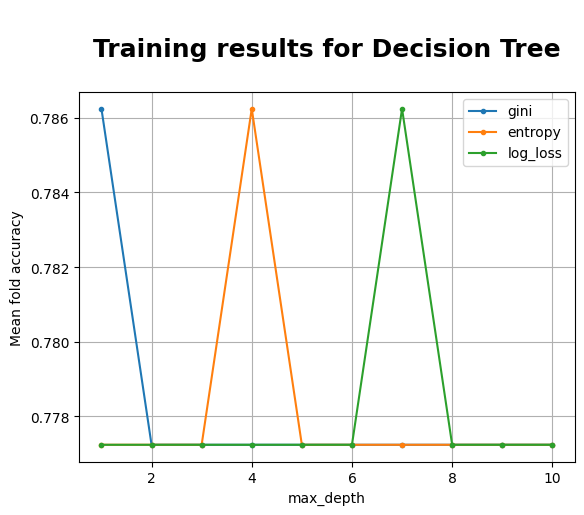

Best model accuracy: 0.7862
Best model parameters: {'criterion': 'gini', 'max_depth': 1}


In [97]:
# Initialize DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=33)

# Initialize GridSearchCV
dt_grid_search = GridSearchCV(dt, dt_param_grid, scoring='accuracy', cv=cv_obj)

# Fit the model
dt_grid_search.fit(df_train_pred.drop(['Kmeans_lbl', 'Survived'], axis=1), df_train_pred['Survived'])

# Extract results
dt_training_results = dt_grid_search.cv_results_
best_dt_params = dt_grid_search.best_params_
best_dt_accuracy = dt_grid_search.best_score_
best_dt_model = dt_grid_search.best_estimator_

# Get mean accuracies from training results
gini_accuracies = dt_training_results['mean_test_score'][::3]
entropy_accuracies = dt_training_results['mean_test_score'][1::3]
log_loss_accuracies = dt_training_results['mean_test_score'][2::3]

# Plot the results
plt.plot(range(1, 11), gini_accuracies, marker='.', label='gini')
plt.plot(range(1, 11), entropy_accuracies, marker='.', label='entropy')
plt.plot(range(1, 11), log_loss_accuracies, marker='.', label='log_loss')
plt.xlabel('max_depth')
plt.ylabel('Mean fold accuracy')
plt.title('\nTraining results for Decision Tree\n', fontsize=18, weight='bold')
plt.legend()
plt.grid(True)
plt.show()

# Print the best model accuracy and parameters
print(f'Best model accuracy: {best_dt_accuracy:.4f}')
print(f'Best model parameters: {best_dt_params}')

In [98]:
# Using best DT model to making predictions with test data
dt_predicts = best_dt_model.predict(df_test[['Pclass', 'Sex_Num']])

# Adding DT predictions to original test df
df_test['Survived_DT_2in'] = dt_predicts
df_test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Sex_Num,Embarked_Num,Ticket_Num,Kmeans_lbl,Survived_KNN_2in,Survived_GaussianNB_2in,Survived_SVM_2in,Survived_DT_3in,Survived_DT_2in
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,Q,1,1,152,1,0,0,0,0,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,S,0,2,221,1,1,1,1,0,1
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,Q,1,1,73,0,0,0,0,0,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,S,1,2,147,1,0,0,0,0,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,S,0,2,138,2,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,20.0,0,0,A.5. 3236,8.0500,S,1,2,267,1,0,0,0,0,0
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C,0,0,324,0,1,1,1,1,1
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,S,1,2,346,1,0,0,0,0,0
416,1308,3,"Ware, Mr. Frederick",male,40.0,0,0,359309,8.0500,S,1,2,220,1,0,0,0,0,0


In [99]:
# Generating submissions file
pd.DataFrame({'PassengerId': df_test['PassengerId'], 'Survived': df_test['Survived_DT_2in']}).to_csv('titanic/results/DT_2in_submission_file.csv', index=False)

In [100]:
# Uploading data to Kaggle
!kaggle competitions submit -c titanic -f titanic/results/DT_2in_submission_file.csv -m "DT: criterion=gini and max_depth=1. Input: Pclass and Sex_Num. 5 folds in cross-validation."

# DT Acc --> 76.555 %

100% 2.77k/2.77k [00:00<00:00, 11.7kB/s]
Successfully submitted to Titanic - Machine Learning from Disaster

In [101]:
# Removing labels of not selected models
df_test.drop('Survived_DT_3in', axis=1, inplace=True)

# Removing CSVs of not selected models
!rm titanic/results/DT_3in_submission_file.csv

## Ensembles

To finalise with ML options I am gonna use ensembles. The ensembles are a set of multiple decision trees which work together to perform better. 2 main options: RandomForest and Boosting trees.

### Random Forest

In [102]:
# Define the parameter grid for RandomForest
rf_param_grid = {
    'n_estimators': list(range(10, 101, 10)),
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': list(range(1, 16)),
    'max_features': ['sqrt', 'log2']
}

# Initialize RandomForestClassifier
rf = RandomForestClassifier(random_state=33)

# Initialize GridSearchCV
rf_grid_search = GridSearchCV(rf, rf_param_grid, scoring='accuracy', cv=cv_obj)

# Fit the model
rf_grid_search.fit(df_train_pred.drop(['Survived'], axis=1), df_train_pred['Survived'])

# Extract results
best_rf_params = rf_grid_search.best_params_
best_rf_accuracy = rf_grid_search.best_score_
best_rf_model = rf_grid_search.best_estimator_

# Print the best model accuracy and parameters
print(f'Best model accuracy: {best_rf_accuracy:.4f}')
print(f'Best model parameters: {best_rf_params}')

Best model accuracy: 0.8065
Best model parameters: {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'n_estimators': 40}


In [103]:
# Using best RF model to making predictions with test data
rf_predicts = best_rf_model.predict(df_test[['Pclass', 'Sex_Num', 'Kmeans_lbl']])

# Adding RF predictions to original test df
df_test['Survived_RF_3in'] = rf_predicts
df_test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Sex_Num,Embarked_Num,Ticket_Num,Kmeans_lbl,Survived_KNN_2in,Survived_GaussianNB_2in,Survived_SVM_2in,Survived_DT_2in,Survived_RF_3in
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,Q,1,1,152,1,0,0,0,0,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,S,0,2,221,1,1,1,1,1,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,Q,1,1,73,0,0,0,0,0,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,S,1,2,147,1,0,0,0,0,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,S,0,2,138,2,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,20.0,0,0,A.5. 3236,8.0500,S,1,2,267,1,0,0,0,0,0
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C,0,0,324,0,1,1,1,1,1
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,S,1,2,346,1,0,0,0,0,0
416,1308,3,"Ware, Mr. Frederick",male,40.0,0,0,359309,8.0500,S,1,2,220,1,0,0,0,0,0


In [104]:
# Generating submissions file
pd.DataFrame({'PassengerId': df_test['PassengerId'], 'Survived': df_test['Survived_RF_3in']}).to_csv('titanic/results/RF_3in_submission_file.csv', index=False)

In [105]:
# Uploading data to Kaggle
#!kaggle competitions submit -c titanic -f titanic/results/RF_3in_submission_file.csv -m "RF: criterion=gini, max_depth=4, max_features=sqrt and n_estimators=40. Input: Pclass, Sex_Num and Kmeans_lbl. 5 folds in cross-validation."

# RF Acc --> 66.985 %

One more time let's try to reduce model's complexity.

In [106]:
# Initialize RandomForestClassifier
rf = RandomForestClassifier(random_state=33)

# Initialize GridSearchCV
rf_grid_search = GridSearchCV(rf, rf_param_grid, scoring='accuracy', cv=cv_obj)

# Fit the model
rf_grid_search.fit(df_train_pred.drop(['Kmeans_lbl', 'Survived'], axis=1), df_train_pred['Survived'])

# Extract results
best_rf_params = rf_grid_search.best_params_
best_rf_accuracy = rf_grid_search.best_score_
best_rf_model = rf_grid_search.best_estimator_

# Print the best model accuracy and parameters
print(f'Best model accuracy: {best_rf_accuracy:.4f}')
print(f'Best model parameters: {best_rf_params}')

Best model accuracy: 0.7918
Best model parameters: {'criterion': 'gini', 'max_depth': 3, 'max_features': 'sqrt', 'n_estimators': 20}


In [107]:
# Using best RF model to making predictions with test data
rf_predicts = best_rf_model.predict(df_test[['Pclass', 'Sex_Num']])

# Adding RF predictions to original test df
df_test['Survived_RF_2in'] = rf_predicts
df_test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Sex_Num,Embarked_Num,Ticket_Num,Kmeans_lbl,Survived_KNN_2in,Survived_GaussianNB_2in,Survived_SVM_2in,Survived_DT_2in,Survived_RF_3in,Survived_RF_2in
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,Q,1,1,152,1,0,0,0,0,0,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,S,0,2,221,1,1,1,1,1,0,1
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,Q,1,1,73,0,0,0,0,0,0,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,S,1,2,147,1,0,0,0,0,0,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,S,0,2,138,2,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,20.0,0,0,A.5. 3236,8.0500,S,1,2,267,1,0,0,0,0,0,0
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C,0,0,324,0,1,1,1,1,1,1
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,S,1,2,346,1,0,0,0,0,0,0
416,1308,3,"Ware, Mr. Frederick",male,40.0,0,0,359309,8.0500,S,1,2,220,1,0,0,0,0,0,0


In [108]:
# Generating submissions file
pd.DataFrame({'PassengerId': df_test['PassengerId'], 'Survived': df_test['Survived_RF_2in']}).to_csv('titanic/results/RF_2in_submission_file.csv', index=False)

In [109]:
# Uploading data to Kaggle
#!kaggle competitions submit -c titanic -f titanic/results/RF_2in_submission_file.csv -m "DT: criterion=gini, max_depth=3, max_features=sqrt and n_estimators=20. Input: Pclass and Sex_Num. 5 folds in cross-validation."

# RF Acc --> 76.555 %

In [110]:
# Removing labels of not selected models
df_test.drop('Survived_RF_3in', axis=1, inplace=True)

# Removing CSVs of not selected models
!rm titanic/results/RF_3in_submission_file.csv

### Adaboost

In [111]:
# Initialize cross-validation
cv_obj = KFold(n_splits=5, shuffle=True, random_state=33)

# Define the parameter grid for AdaBoost
adaboost_param_grid = {
    'n_estimators': list(range(10, 101, 10)),
    'learning_rate': [0.1, 0.5, 0.01, 0.05, 0.001, 0.005]
}

# Initialize AdaBoostClassifier
adaboost = AdaBoostClassifier(random_state=33)

# Initialize GridSearchCV
adaboost_grid_search = GridSearchCV(adaboost, adaboost_param_grid, scoring='accuracy', cv=cv_obj)

# Fit the model
adaboost_grid_search.fit(df_train_pred.drop(['Survived'], axis=1), df_train_pred['Survived'])

# Extract results
best_adaboost_params = adaboost_grid_search.best_params_
best_adaboost_accuracy = adaboost_grid_search.best_score_
best_adaboost_model = adaboost_grid_search.best_estimator_

# Print the best model accuracy and parameters
print(f'Best model accuracy: {best_adaboost_accuracy:.4f}')
print(f'Best model parameters: {best_adaboost_params}')

Best model accuracy: 0.7862
Best model parameters: {'learning_rate': 0.1, 'n_estimators': 10}


In [112]:
# Using best AB model to making predictions with test data
adaboost_predicts = best_adaboost_model.predict(df_test[['Pclass', 'Sex_Num', 'Kmeans_lbl']])

# Adding AB predictions to original test df
df_test['Survived_AB_3in'] = adaboost_predicts
df_test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Sex_Num,Embarked_Num,Ticket_Num,Kmeans_lbl,Survived_KNN_2in,Survived_GaussianNB_2in,Survived_SVM_2in,Survived_DT_2in,Survived_RF_2in,Survived_AB_3in
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,Q,1,1,152,1,0,0,0,0,0,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,S,0,2,221,1,1,1,1,1,1,1
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,Q,1,1,73,0,0,0,0,0,0,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,S,1,2,147,1,0,0,0,0,0,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,S,0,2,138,2,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,20.0,0,0,A.5. 3236,8.0500,S,1,2,267,1,0,0,0,0,0,0
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C,0,0,324,0,1,1,1,1,1,1
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,S,1,2,346,1,0,0,0,0,0,0
416,1308,3,"Ware, Mr. Frederick",male,40.0,0,0,359309,8.0500,S,1,2,220,1,0,0,0,0,0,0


In [113]:
# Generating submissions file
pd.DataFrame({'PassengerId': df_test['PassengerId'], 'Survived': df_test['Survived_AB_3in']}).to_csv('titanic/results/AB_3in_submission_file.csv', index=False)

In [114]:
# Uploading data to Kaggle
#!kaggle competitions submit -c titanic -f titanic/results/AB_3in_submission_file.csv -m "AB: lr=0.1, and n_estimators=10. Input: Pclass, Sex_Num and Kmeans_lbl. 5 folds in cross-validation."

# AB Acc --> 76.555 %

Reducing model's complexity.

In [115]:
# Initialize AdaBoostClassifier
adaboost = AdaBoostClassifier(random_state=33)

# Initialize GridSearchCV
adaboost_grid_search = GridSearchCV(adaboost, adaboost_param_grid, scoring='accuracy', cv=cv_obj)

# Fit the model
adaboost_grid_search.fit(df_train_pred.drop(['Kmeans_lbl', 'Survived'], axis=1), df_train_pred['Survived'])

# Extract results
best_adaboost_params = adaboost_grid_search.best_params_
best_adaboost_accuracy = adaboost_grid_search.best_score_
best_adaboost_model = adaboost_grid_search.best_estimator_

# Print the best model accuracy and parameters
print(f'Best model accuracy: {best_adaboost_accuracy:.4f}')
print(f'Best model parameters: {best_adaboost_params}')

Best model accuracy: 0.7862
Best model parameters: {'learning_rate': 0.1, 'n_estimators': 10}


In [116]:
# Using best AB model to making predictions with test data
adaboost_predicts = best_adaboost_model.predict(df_test[['Pclass', 'Sex_Num']])

# Adding AB predictions to original test df
df_test['Survived_AB_2in'] = adaboost_predicts
df_test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,...,Embarked_Num,Ticket_Num,Kmeans_lbl,Survived_KNN_2in,Survived_GaussianNB_2in,Survived_SVM_2in,Survived_DT_2in,Survived_RF_2in,Survived_AB_3in,Survived_AB_2in
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,Q,...,1,152,1,0,0,0,0,0,0,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,S,...,2,221,1,1,1,1,1,1,1,1
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,Q,...,1,73,0,0,0,0,0,0,0,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,S,...,2,147,1,0,0,0,0,0,0,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,S,...,2,138,2,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,20.0,0,0,A.5. 3236,8.0500,S,...,2,267,1,0,0,0,0,0,0,0
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C,...,0,324,0,1,1,1,1,1,1,1
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,S,...,2,346,1,0,0,0,0,0,0,0
416,1308,3,"Ware, Mr. Frederick",male,40.0,0,0,359309,8.0500,S,...,2,220,1,0,0,0,0,0,0,0


In [117]:
# Generating submissions file
pd.DataFrame({'PassengerId': df_test['PassengerId'], 'Survived': df_test['Survived_AB_2in']}).to_csv('titanic/results/AB_2in_submission_file.csv', index=False)

In [118]:
# Uploading data to Kaggle
#!kaggle competitions submit -c titanic -f titanic/results/AB_2in_submission_file.csv -m "AB: lr=0.1, and n_estimators=10. Input: Pclass and Sex_Num. 5 folds in cross-validation."

# AB Acc --> 76.555 %

In [119]:
# Removing labels of not selected models
df_test.drop('Survived_AB_3in', axis=1, inplace=True)

# Removing CSVs of not selected models
!rm titanic/results/AB_3in_submission_file.csv

### Gradient Boost

In [120]:
# Define the parameter grid for GradientBoosting
gradientboost_param_grid = {
    'n_estimators': list(range(10, 101, 10)),
    'learning_rate': [0.1, 0.5, 0.01, 0.05, 0.001, 0.005],
    'max_depth': list(range(1, 11))
}

# Initialize GradientBoostingClassifier
gradientboost = GradientBoostingClassifier(random_state=33)

# Initialize GridSearchCV
gradientboost_grid_search = GridSearchCV(gradientboost, gradientboost_param_grid, scoring='accuracy', cv=cv_obj)

# Fit the model
gradientboost_grid_search.fit(df_train_pred.drop(['Survived'], axis=1), df_train_pred['Survived'])

# Extract results
best_gradientboost_params = gradientboost_grid_search.best_params_
best_gradientboost_accuracy = gradientboost_grid_search.best_score_
best_gradientboost_model = gradientboost_grid_search.best_estimator_

# Print the best model accuracy and parameters
print(f'Best model accuracy: {best_gradientboost_accuracy:.4f}')
print(f'Best model parameters: {best_gradientboost_params}')

Best model accuracy: 0.8065
Best model parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 60}


In [121]:
# Using best GB model to making predictions with test data
gradientboost_predicts = best_gradientboost_model.predict(df_test[['Pclass', 'Sex_Num', 'Kmeans_lbl']])

# Adding GB predictions to original test df
df_test['Survived_GB_3in'] = gradientboost_predicts
df_test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,...,Embarked_Num,Ticket_Num,Kmeans_lbl,Survived_KNN_2in,Survived_GaussianNB_2in,Survived_SVM_2in,Survived_DT_2in,Survived_RF_2in,Survived_AB_2in,Survived_GB_3in
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,Q,...,1,152,1,0,0,0,0,0,0,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,S,...,2,221,1,1,1,1,1,1,1,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,Q,...,1,73,0,0,0,0,0,0,0,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,S,...,2,147,1,0,0,0,0,0,0,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,S,...,2,138,2,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,20.0,0,0,A.5. 3236,8.0500,S,...,2,267,1,0,0,0,0,0,0,0
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C,...,0,324,0,1,1,1,1,1,1,1
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,S,...,2,346,1,0,0,0,0,0,0,0
416,1308,3,"Ware, Mr. Frederick",male,40.0,0,0,359309,8.0500,S,...,2,220,1,0,0,0,0,0,0,0


In [122]:
# Generating submissions file
pd.DataFrame({'PassengerId': df_test['PassengerId'], 'Survived': df_test['Survived_GB_3in']}).to_csv('titanic/results/GB_3in_submission_file.csv', index=False)

In [123]:
# Uploading data to Kaggle
#!kaggle competitions submit -c titanic -f titanic/results/GB_3in_submission_file.csv -m "GB: n_estimators=60, rl=0.1 and max_depth=3. Input: Pclass, Sex_Num and Kmeans_lbl. 5 folds in cross-validation."

# GB Acc --> 66.985 %

Reducing model's complexity.

In [124]:
# Initialize GradientBoostingClassifier
gradientboost = GradientBoostingClassifier(random_state=33)

# Initialize GridSearchCV
gradientboost_grid_search = GridSearchCV(gradientboost, gradientboost_param_grid, scoring='accuracy', cv=cv_obj)

# Fit the model
gradientboost_grid_search.fit(df_train_pred.drop(['Kmeans_lbl', 'Survived'], axis=1), df_train_pred['Survived'])

# Extract results
best_gradientboost_params = gradientboost_grid_search.best_params_
best_gradientboost_accuracy = gradientboost_grid_search.best_score_
best_gradientboost_model = gradientboost_grid_search.best_estimator_

# Print the best model accuracy and parameters
print(f'Best model accuracy: {best_gradientboost_accuracy:.4f}')
print(f'Best model parameters: {best_gradientboost_params}')

Best model accuracy: 0.7862
Best model parameters: {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 10}


In [125]:
# Using best GB model to making predictions with test data
gradientboost_predicts = best_gradientboost_model.predict(df_test[['Pclass', 'Sex_Num']])

# Adding GB predictions to original test df
df_test['Survived_GB_2in'] = gradientboost_predicts
df_test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,...,Ticket_Num,Kmeans_lbl,Survived_KNN_2in,Survived_GaussianNB_2in,Survived_SVM_2in,Survived_DT_2in,Survived_RF_2in,Survived_AB_2in,Survived_GB_3in,Survived_GB_2in
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,Q,...,152,1,0,0,0,0,0,0,0,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,S,...,221,1,1,1,1,1,1,1,0,1
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,Q,...,73,0,0,0,0,0,0,0,0,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,S,...,147,1,0,0,0,0,0,0,0,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,S,...,138,2,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,20.0,0,0,A.5. 3236,8.0500,S,...,267,1,0,0,0,0,0,0,0,0
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C,...,324,0,1,1,1,1,1,1,1,1
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,S,...,346,1,0,0,0,0,0,0,0,0
416,1308,3,"Ware, Mr. Frederick",male,40.0,0,0,359309,8.0500,S,...,220,1,0,0,0,0,0,0,0,0


In [126]:
# Generating submissions file
pd.DataFrame({'PassengerId': df_test['PassengerId'], 'Survived': df_test['Survived_GB_2in']}).to_csv('titanic/results/GB_2in_submission_file.csv', index=False)

In [127]:
# Uploading data to Kaggle
#!kaggle competitions submit -c titanic -f titanic/results/GB_2in_submission_file.csv -m "GB: n_estimators=10, rl=0.1 and max_depth=1. Input: Pclass and Sex_Num. 5 folds in cross-validation."

# GB Acc --> 76.555 %

In [192]:
# Removing labels of not selected models
df_test.drop('Survived_GB_3in', axis=1, inplace=True)

# Removing CSVs of not selected models
!rm titanic/results/GB_3in_submission_file.csv

## Deep Learning

Finally, let's use Deep Learning to predict if a passenger would survive or not.

In [128]:
# Method to show training information
def show_training_info(hist_object):
  plt.style.use("ggplot")
  plt.figure()
  plt.plot(hist_object["loss"], label="train_loss")
  plt.plot(hist_object["val_loss"], label="val_loss")
  plt.plot(hist_object["accuracy"], label="train_acc")
  plt.plot(hist_object["val_accuracy"], label="val_acc")
  plt.title("Training and validation losses and accuracies")
  plt.xlabel("Epoch #")
  plt.ylabel("Loss/Accuracy")
  plt.legend()

  # Showing best epoch and its info
  best_epoch_idx = np.argmax(hist_object['val_accuracy'])
  best_epoch_train_loss = hist_object['loss'][best_epoch_idx]
  best_epoch_train_accuracy = hist_object['accuracy'][best_epoch_idx]
  best_epoch_val_loss = hist_object['val_loss'][best_epoch_idx]
  best_epoch_val_accuracy = hist_object['val_accuracy'][best_epoch_idx]
  print("Best epoch:", best_epoch_idx+1)
  print("Best epoch train loss: {:.4f}".format(best_epoch_train_loss))
  print("Best epoch train accuracy: {:.4f}".format(best_epoch_train_accuracy))
  print("Best epoch validation loss: {:.4f}".format(best_epoch_val_loss))
  print("Best epoch validation accuracy: {:.4f}".format(best_epoch_val_accuracy))

In [129]:
# Split the dataset into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(df_train_pred[['Pclass', 'Sex_Num', 'Kmeans_lbl']], df_train_pred['Survived'], test_size=0.2, random_state=33)

# Normalise the data to improve convergence
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)

In [179]:
# Building the model
t_model = Sequential(name='Titanic_Model')

# Input layer
t_model.add(Dense(8, input_dim=3, activation='relu', name='titanic_input_layer'))

# Hidden layer 1
t_model.add(Dense(4, activation='relu', name='titanic_hidden_layer_1'))

# Output layer
t_model.add(Dense(1, activation='sigmoid', name='titanic_output_layer'))

# Showing model
t_model.summary()

Model: "Titanic_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 titanic_input_layer (Dense  (None, 8)                 32        
 )                                                               
                                                                 
 titanic_hidden_layer_1 (De  (None, 4)                 36        
 nse)                                                            
                                                                 
 titanic_output_layer (Dens  (None, 1)                 5         
 e)                                                              
                                                                 
Total params: 73 (292.00 Byte)
Trainable params: 73 (292.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [180]:
# Compiling the model
t_model.compile(optimizer=Adam(learning_rate=0.0025), loss='binary_crossentropy', metrics=['accuracy'])

# Defining early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Training
t_model_hist = t_model.fit(x_train, y_train, epochs=50, batch_size=16, callbacks=[early_stopping], validation_data=(x_val, y_val))

Epoch 1/50
45/45 [==============================] - 1s 6ms/step - loss: 0.6533 - accuracy: 0.6568 - val_loss: 0.5386 - val_accuracy: 0.7809
Epoch 2/50
45/45 [==============================] - 0s 3ms/step - loss: 0.5231 - accuracy: 0.7820 - val_loss: 0.4783 - val_accuracy: 0.8090
Epoch 3/50
45/45 [==============================] - 0s 3ms/step - loss: 0.4842 - accuracy: 0.8031 - val_loss: 0.4506 - val_accuracy: 0.8146
Epoch 4/50
45/45 [==============================] - 0s 3ms/step - loss: 0.4669 - accuracy: 0.7792 - val_loss: 0.4439 - val_accuracy: 0.8146
Epoch 5/50
45/45 [==============================] - 0s 3ms/step - loss: 0.4587 - accuracy: 0.7792 - val_loss: 0.4423 - val_accuracy: 0.8146
Epoch 6/50
45/45 [==============================] - 0s 3ms/step - loss: 0.4532 - accuracy: 0.7848 - val_loss: 0.4445 - val_accuracy: 0.8090
Epoch 7/50
45/45 [==============================] - 0s 3ms/step - loss: 0.4499 - accuracy: 0.7904 - val_loss: 0.4460 - val_accuracy: 0.8090
Epoch 8/50
45/45 [==

Best epoch: 3
Best epoch train loss: 0.4842
Best epoch train accuracy: 0.8031
Best epoch validation loss: 0.4506
Best epoch validation accuracy: 0.8146


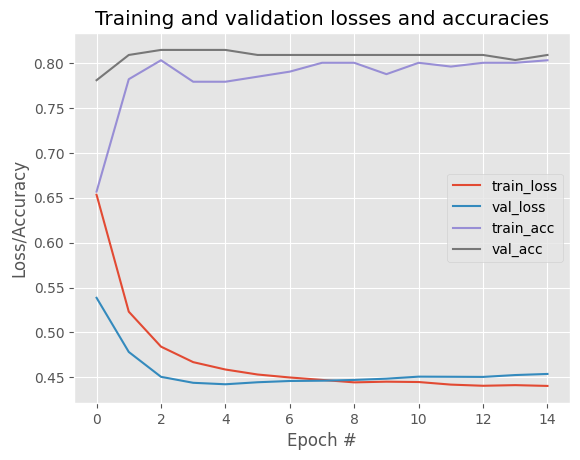

In [182]:
# Showing training info
show_training_info(t_model_hist.history)

In [193]:
# Normalise the data as we did with train data
x_test = scaler.transform(df_test_pred)

# Making the predictions with DL model
t_model_predictions = t_model.predict(x_test)

# Adding DL predictions to the original test df
df_test['Survived_DL_3in'] = (t_model_predictions > 0.5).astype(int)
df_test

14/14 [==============================] - 0s 2ms/step


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,...,Ticket_Num,Kmeans_lbl,Survived_KNN_2in,Survived_GaussianNB_2in,Survived_SVM_2in,Survived_DT_2in,Survived_RF_2in,Survived_AB_2in,Survived_GB_2in,Survived_DL_3in
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,Q,...,152,1,0,0,0,0,0,0,0,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,S,...,221,1,1,1,1,1,1,1,1,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,Q,...,73,0,0,0,0,0,0,0,0,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,S,...,147,1,0,0,0,0,0,0,0,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,S,...,138,2,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,20.0,0,0,A.5. 3236,8.0500,S,...,267,1,0,0,0,0,0,0,0,0
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C,...,324,0,1,1,1,1,1,1,1,1
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,S,...,346,1,0,0,0,0,0,0,0,0
416,1308,3,"Ware, Mr. Frederick",male,40.0,0,0,359309,8.0500,S,...,220,1,0,0,0,0,0,0,0,0


In [194]:
# Generating submissions file
pd.DataFrame({'PassengerId': df_test['PassengerId'], 'Survived': df_test['Survived_DL_3in']}).to_csv('titanic/results/DL_3in_submission_file.csv', index=False)

In [195]:
# Uploading data to Kaggle
#!kaggle competitions submit -c titanic -f titanic/results/DL_3in_submission_file.csv -m "DL: lr=0.0025 and bs=16. Input: Pclass, Sex_Num and Kmeans_lbl."

# DL Acc --> 77.033 %

100% 2.77k/2.77k [00:00<00:00, 11.5kB/s]
Successfully submitted to Titanic - Machine Learning from Disaster

Right now, using DL I have achieved the best accuracy with test data. Let's see what happens if I reduce model's complexity.

In [196]:
# Split the dataset into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(df_train_pred[['Pclass', 'Sex_Num']], df_train_pred['Survived'], test_size=0.2, random_state=33)

# Normalise the data to improve convergence
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)

In [238]:
# Building the model
t_model_2in = Sequential(name='Titanic_Model_2in')

# Input layer
t_model_2in.add(Dense(8, input_dim=2, activation='relu', name='input_layer'))

# Hidden layer 1
t_model_2in.add(Dense(4, activation='relu', name='hidden_layer_1'))

# Output layer
t_model_2in.add(Dense(1, activation='sigmoid', name='output_layer'))

# Showing model
t_model_2in.summary()

Model: "Titanic_Model_2in"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (Dense)         (None, 8)                 24        
                                                                 
 hidden_layer_1 (Dense)      (None, 4)                 36        
                                                                 
 output_layer (Dense)        (None, 1)                 5         
                                                                 
Total params: 65 (260.00 Byte)
Trainable params: 65 (260.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [239]:
# Compiling the model
t_model_2in.compile(optimizer=Adam(learning_rate=0.0025), loss='binary_crossentropy', metrics=['accuracy'])

# Defining early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Training
t_model_2in_hist = t_model_2in.fit(x_train, y_train, epochs=50, batch_size=16, callbacks=[early_stopping], validation_data=(x_val, y_val))

Epoch 1/50
45/45 [==============================] - 1s 6ms/step - loss: 0.7259 - accuracy: 0.5091 - val_loss: 0.6380 - val_accuracy: 0.7303
Epoch 2/50
45/45 [==============================] - 0s 3ms/step - loss: 0.6181 - accuracy: 0.6765 - val_loss: 0.5712 - val_accuracy: 0.7360
Epoch 3/50
45/45 [==============================] - 0s 3ms/step - loss: 0.5656 - accuracy: 0.7468 - val_loss: 0.5274 - val_accuracy: 0.7753
Epoch 4/50
45/45 [==============================] - 0s 3ms/step - loss: 0.5339 - accuracy: 0.7426 - val_loss: 0.4990 - val_accuracy: 0.7753
Epoch 5/50
45/45 [==============================] - 0s 3ms/step - loss: 0.5096 - accuracy: 0.7440 - val_loss: 0.4785 - val_accuracy: 0.7753
Epoch 6/50
45/45 [==============================] - 0s 3ms/step - loss: 0.4920 - accuracy: 0.7440 - val_loss: 0.4663 - val_accuracy: 0.7753
Epoch 7/50
45/45 [==============================] - 0s 3ms/step - loss: 0.4763 - accuracy: 0.7525 - val_loss: 0.4536 - val_accuracy: 0.8146
Epoch 8/50
45/45 [==

Best epoch: 7
Best epoch train loss: 0.4763
Best epoch train accuracy: 0.7525
Best epoch validation loss: 0.4536
Best epoch validation accuracy: 0.8146


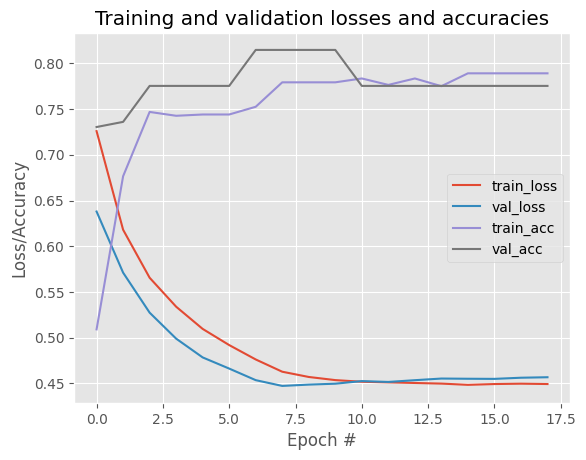

In [240]:
# Showing training info
show_training_info(t_model_2in_hist.history)

In [243]:
# Normalise the data as we did with train data
x_test = scaler.transform(df_test_pred[['Pclass', 'Sex_Num']])

# Making the predictions with DL model
t_model_2in_predictions = t_model_2in.predict(x_test)

# Adding DL predictions to the original test df
df_test['Survived_DL_2in'] = (t_model_2in_predictions > 0.5).astype(int)
df_test

14/14 [==============================] - 0s 2ms/step


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,...,Kmeans_lbl,Survived_KNN_2in,Survived_GaussianNB_2in,Survived_SVM_2in,Survived_DT_2in,Survived_RF_2in,Survived_AB_2in,Survived_GB_2in,Survived_DL_3in,Survived_DL_2in
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,Q,...,1,0,0,0,0,0,0,0,0,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,S,...,1,1,1,1,1,1,1,1,0,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,Q,...,0,0,0,0,0,0,0,0,0,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,S,...,1,0,0,0,0,0,0,0,0,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,S,...,2,1,1,1,1,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,20.0,0,0,A.5. 3236,8.0500,S,...,1,0,0,0,0,0,0,0,0,0
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C,...,0,1,1,1,1,1,1,1,1,1
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,S,...,1,0,0,0,0,0,0,0,0,0
416,1308,3,"Ware, Mr. Frederick",male,40.0,0,0,359309,8.0500,S,...,1,0,0,0,0,0,0,0,0,0


In [244]:
# Generating submissions file
pd.DataFrame({'PassengerId': df_test['PassengerId'], 'Survived': df_test['Survived_DL_2in']}).to_csv('titanic/results/DL_2in_submission_file.csv', index=False)

In [245]:
# Uploading data to Kaggle
!kaggle competitions submit -c titanic -f titanic/results/DL_2in_submission_file.csv -m "DL: lr=0.0025 and bs=16. Input: Pclass and Sex_Num."

# DL Acc --> 77.033 %

100% 2.77k/2.77k [00:00<00:00, 11.8kB/s]
400 - Bad Request - Submission not allowed:  Your team has used its daily Submission allowance (10) today, please try again tomorrow UTC (4.3 hours from now).
